# Import dataset and preprocess

In [1]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pylab
from sklearn.model_selection import train_test_split

In [2]:
def import_dataset():
    uploaded = files.upload()

    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

    with open(fn, 'r') as opened_file:
        txt_lines = opened_file.readlines()

    sequences = []
    label_array = np.zeros(len(txt_lines))
    for i in range (len(txt_lines)):
        line_elements = txt_lines[i].split('\t')
        label_array[i] = int(line_elements[0])
        seq = list(line_elements[1][:-1])
        sequences.append(seq)

    raw_dataset = pd.DataFrame(data=sequences, columns=range(1,201))
    raw_dataset['label'] = label_array
    return raw_dataset

In [ ]:
raw_dataset = import_dataset()
[raw_train, raw_test] = train_test_split(raw_dataset,train_size=0.8, random_state=103)

# Train SVM model

## Analyze results with ROC curve

In [3]:
from sklearn import svm
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import StratifiedKFold

def plot_roc_with_cv(classifier, X_train, Y_train, n_splits, title):
    cv = StratifiedKFold(n_splits=n_splits)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(18, 8))
    for fold, (train, test) in enumerate(cv.split(X_train, Y_train)):
        classifier.fit(X_train[train], Y_train[train])
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X_train[test],
            Y_train[test],
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=title,
    )
    ax.legend(loc="lower right")
    ax.plot(np.linspace(0,1,10), np.linspace(0,1,10), '--',color='black')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()

## R^2 representation

In [8]:
chars = ['A', 'a', 'C', 'c', 'G', 'g', 'T', 't']
real_values = [1, 1/(2 ** 0.5), 0, -1/(2 ** 0.5), -1, -1/(2 ** 0.5), 0, 1/(2 ** 0.5)]
imag_values = [0, 1/(2 ** 0.5), 1, 1/(2 ** 0.5), 0, -1/(2 ** 0.5), -1, -1/(2 ** 0.5)]
new_column_names = range(201,402)

train_real_values = raw_train.replace(chars, real_values)
train_imag_values = raw_train.replace(chars, imag_values)
train_imag_values.rename(columns=dict(zip(train_imag_values.columns, new_column_names)), inplace=True)
train_imag_values.rename(columns={401: 'label'}, inplace=True)
train = pd.concat([train_real_values.iloc[:, 0:200], train_imag_values], axis=1)
X_train = train.iloc[:, 0:400].to_numpy()
Y_train = train['label'].to_numpy()

test_real_values = raw_test.replace(chars, real_values)
test_imag_values = raw_test.replace(chars, imag_values)
test_imag_values.rename(columns=dict(zip(test_imag_values.columns, new_column_names)), inplace=True)
test_imag_values.rename(columns={401: 'label'}, inplace=True)
test = pd.concat([test_real_values.iloc[:, 0:200], test_imag_values], axis=1)
X_test = test.iloc[:, 0:400].to_numpy()
Y_test = test['label'].to_numpy()

# print(X_train)

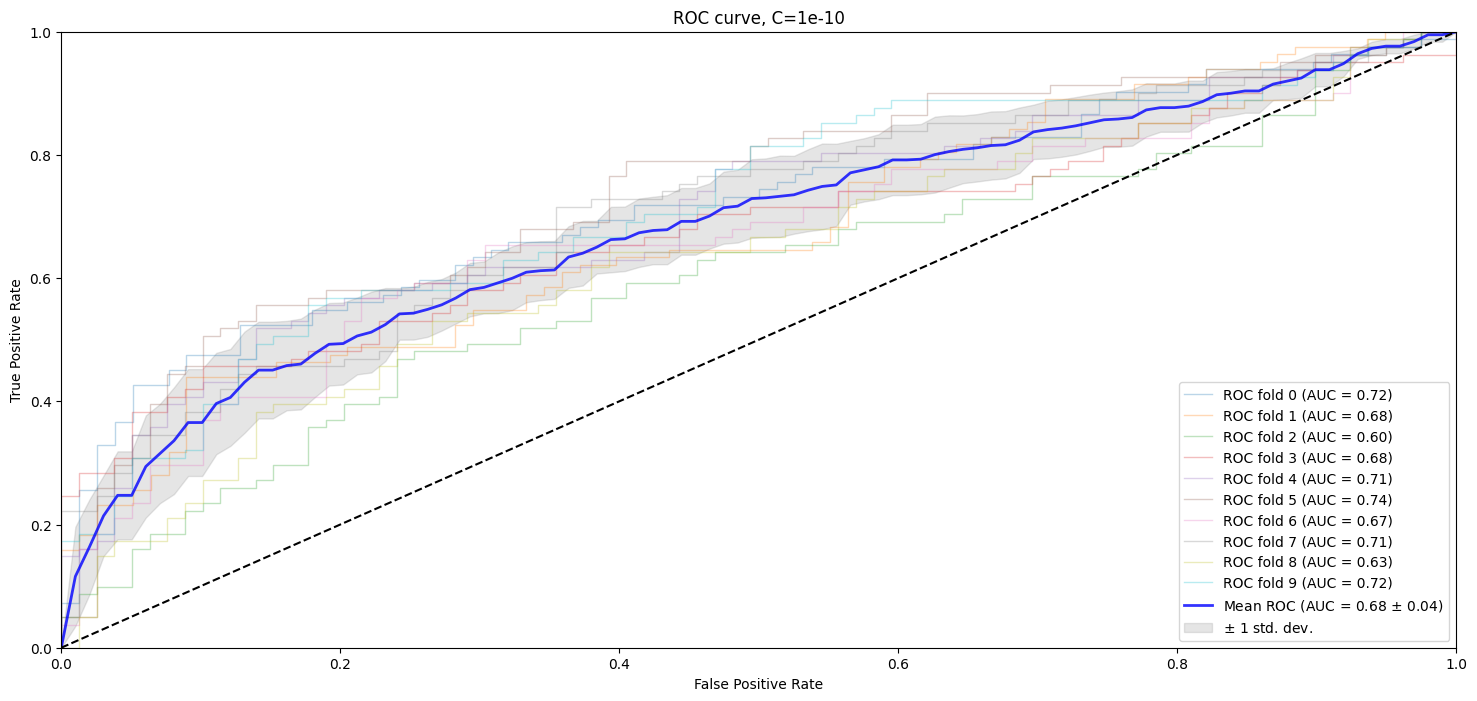

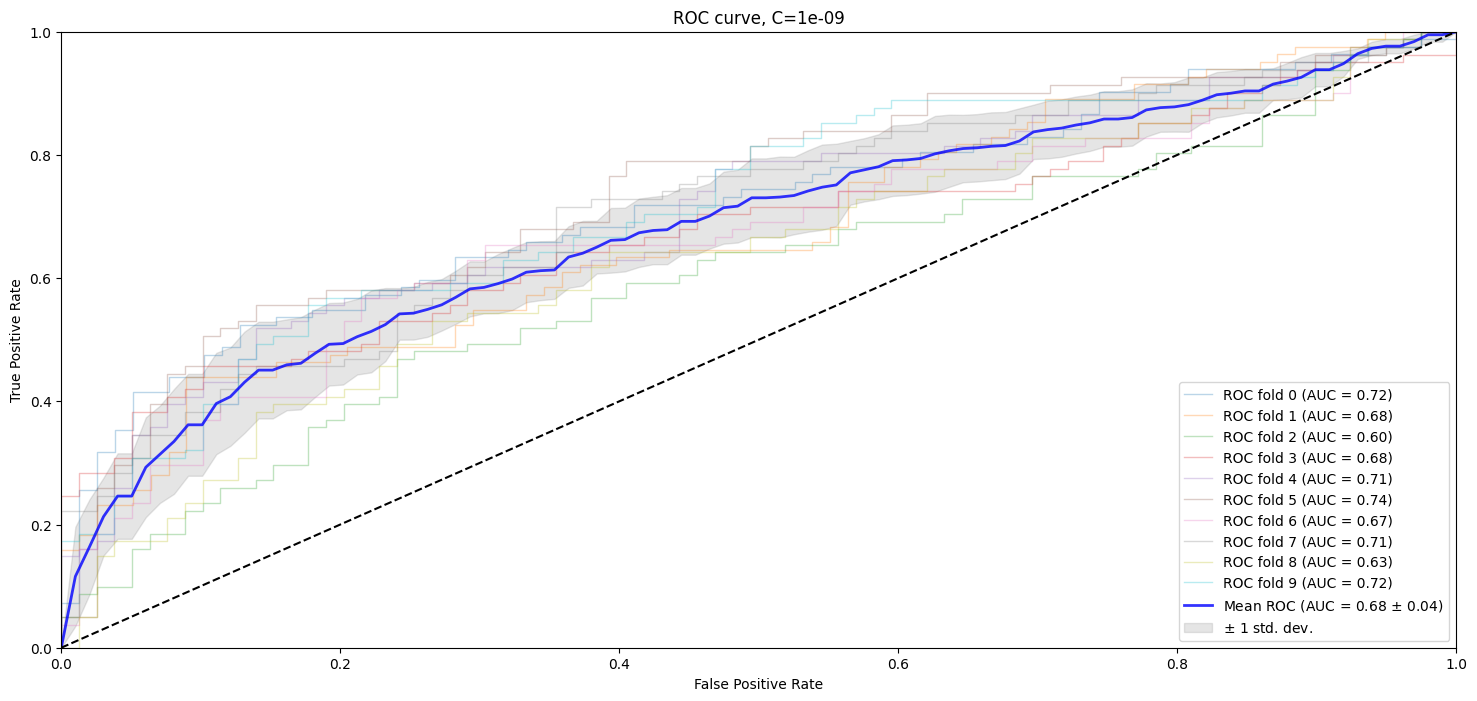

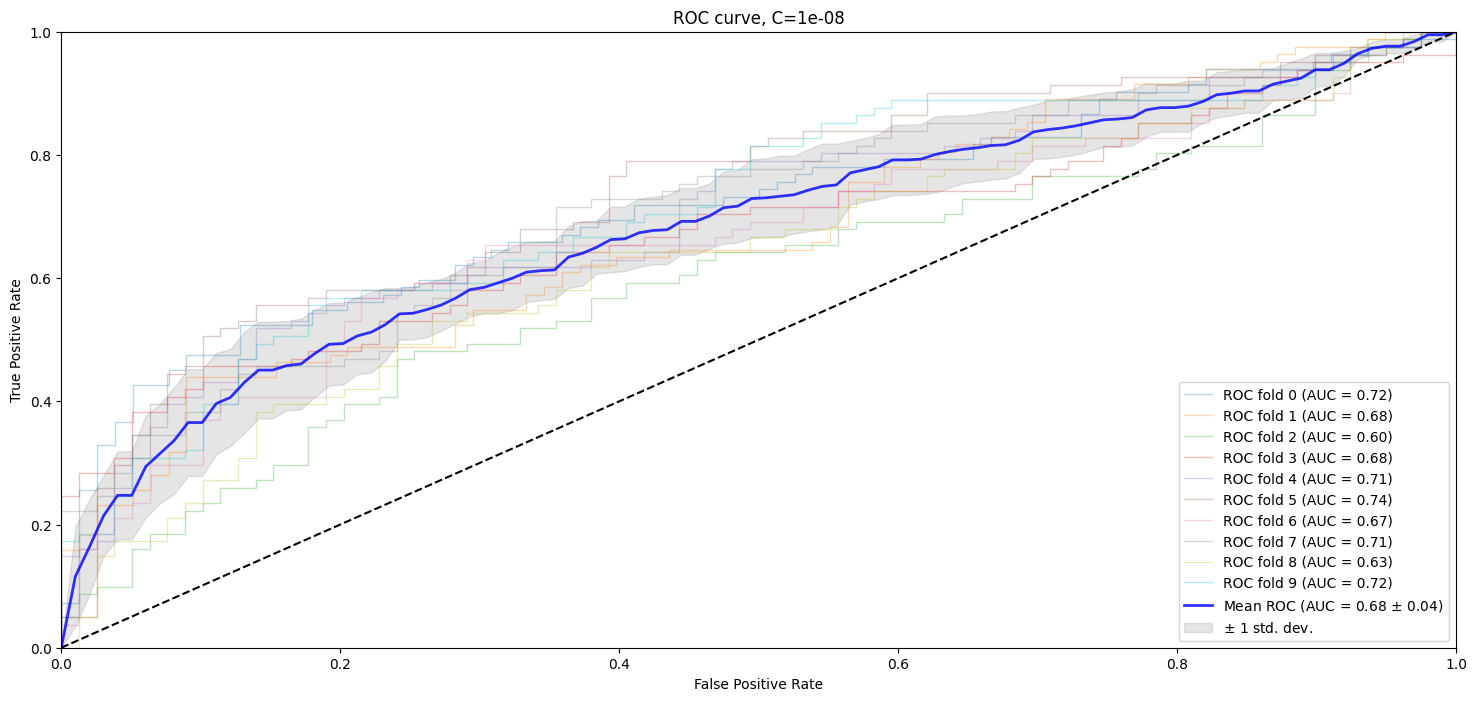

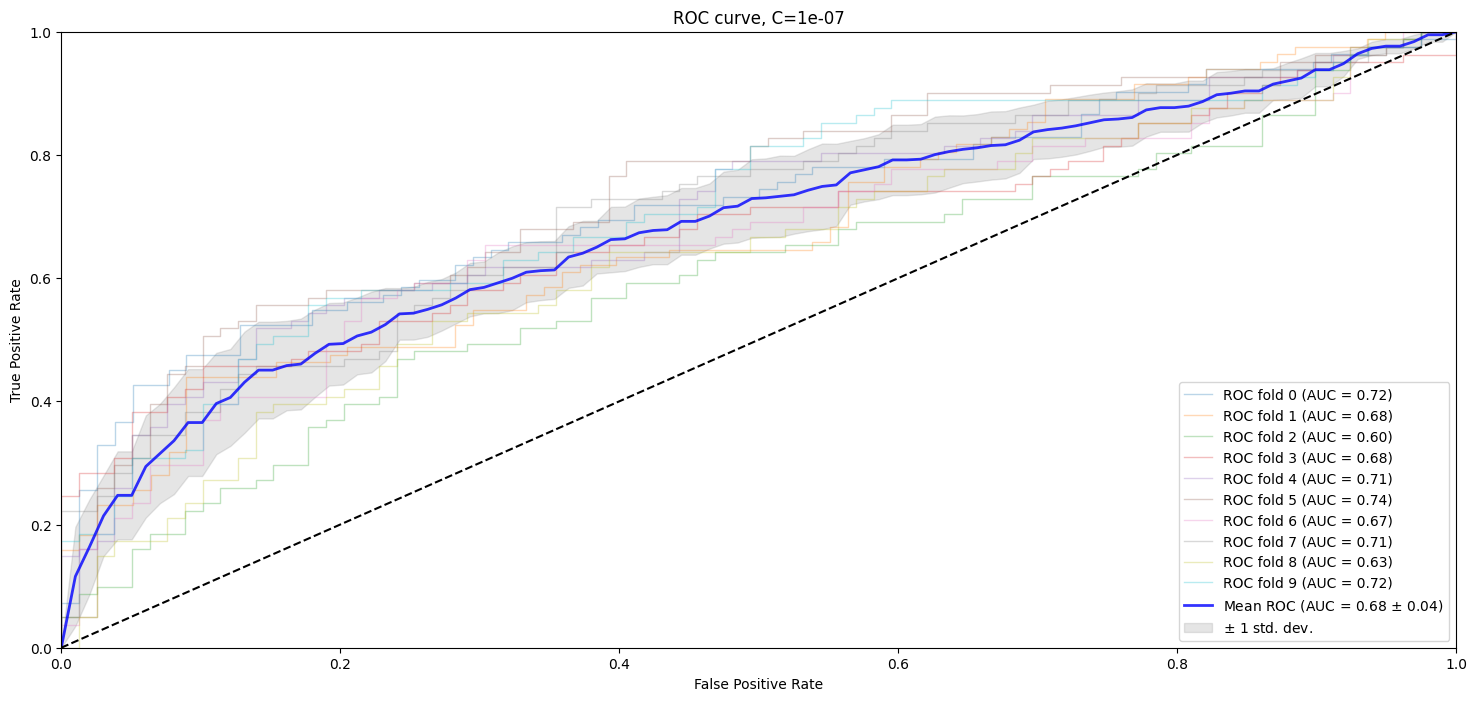

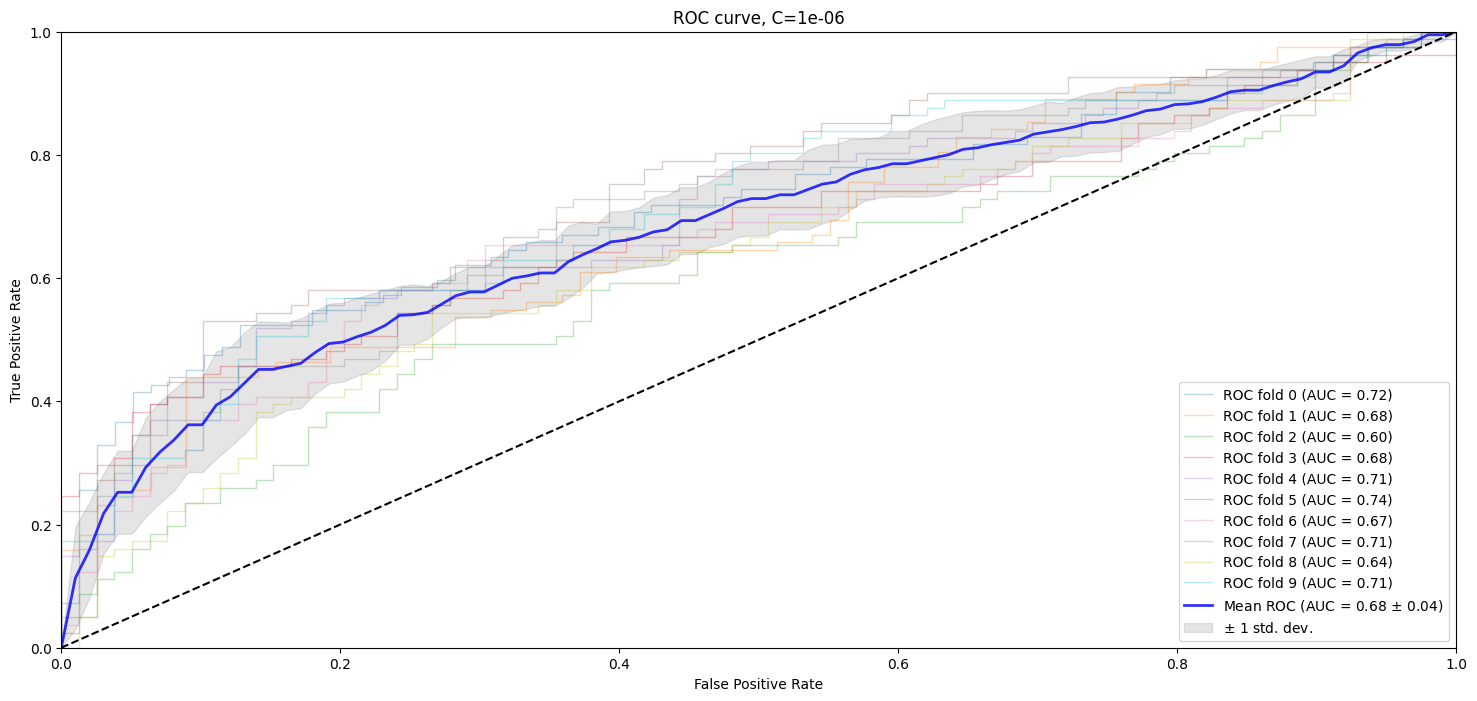

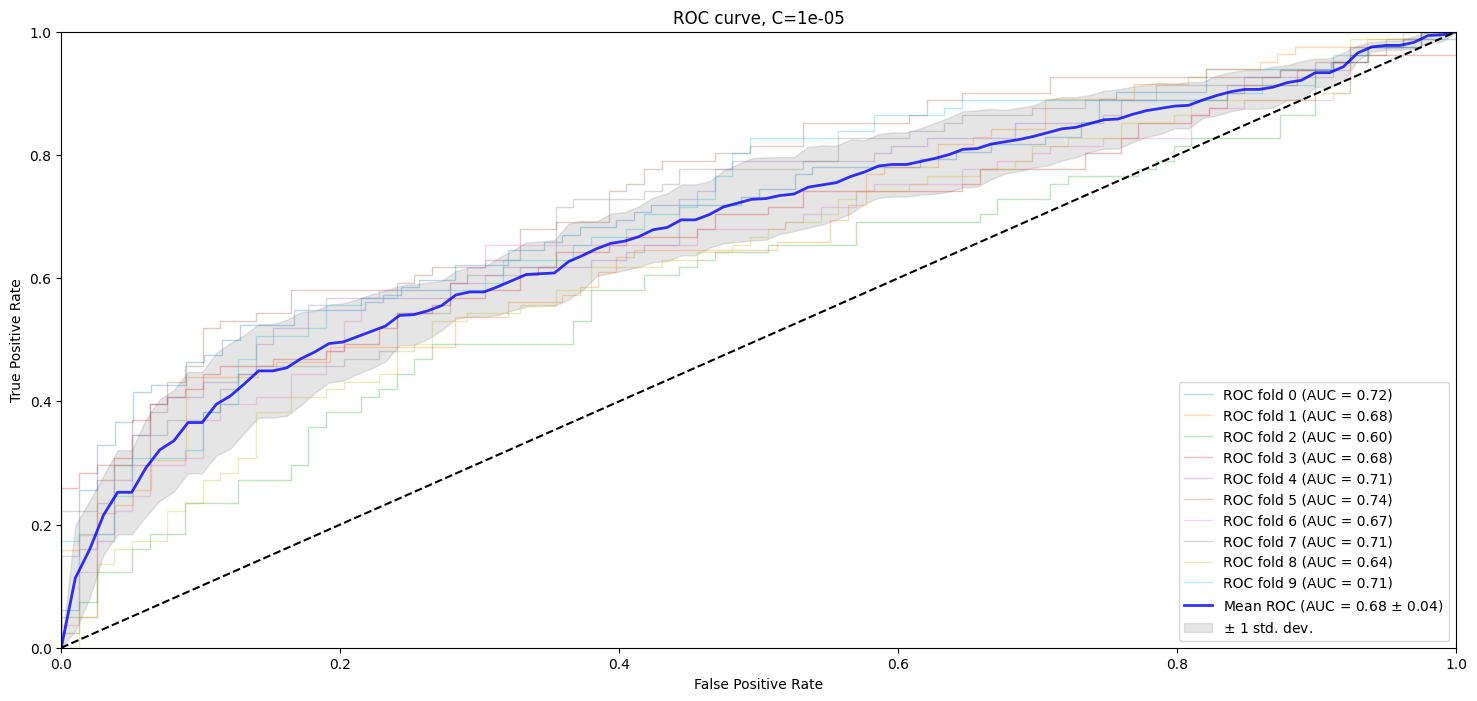

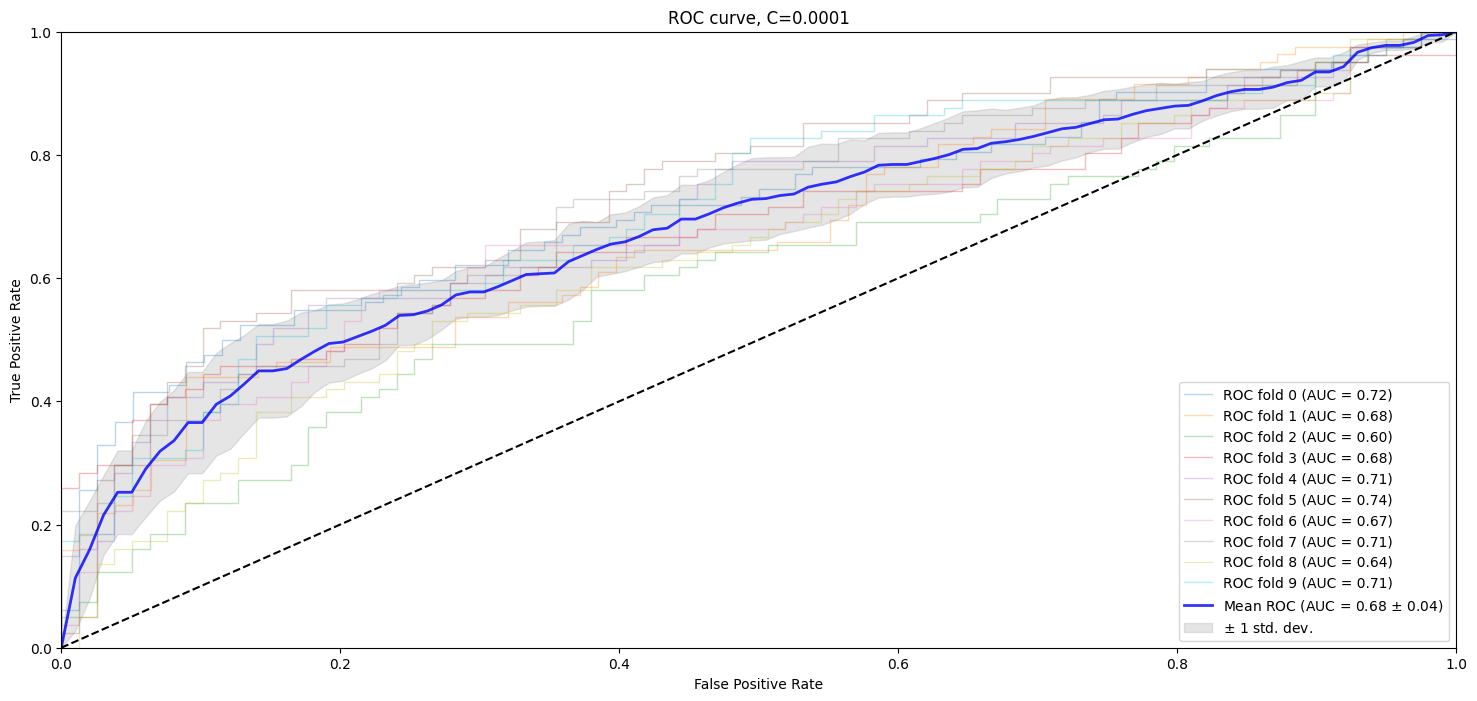

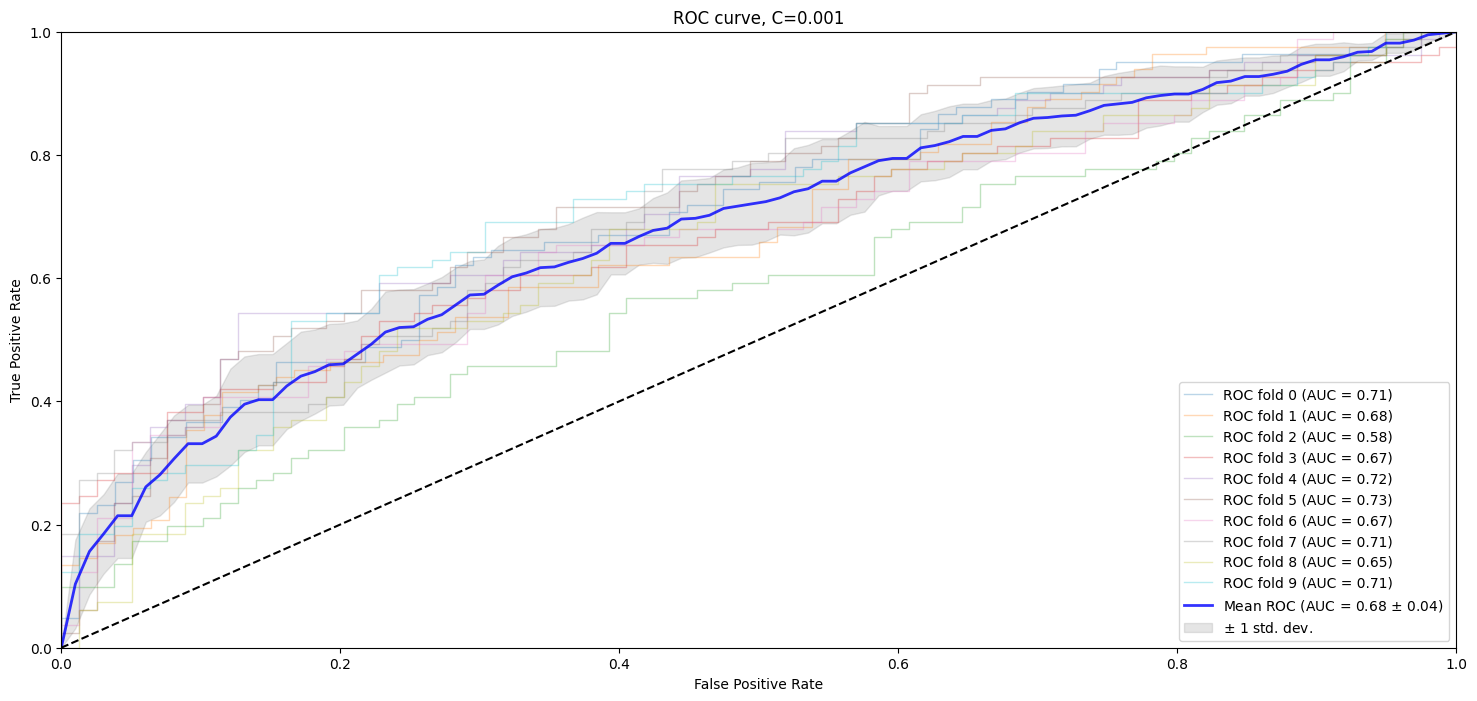

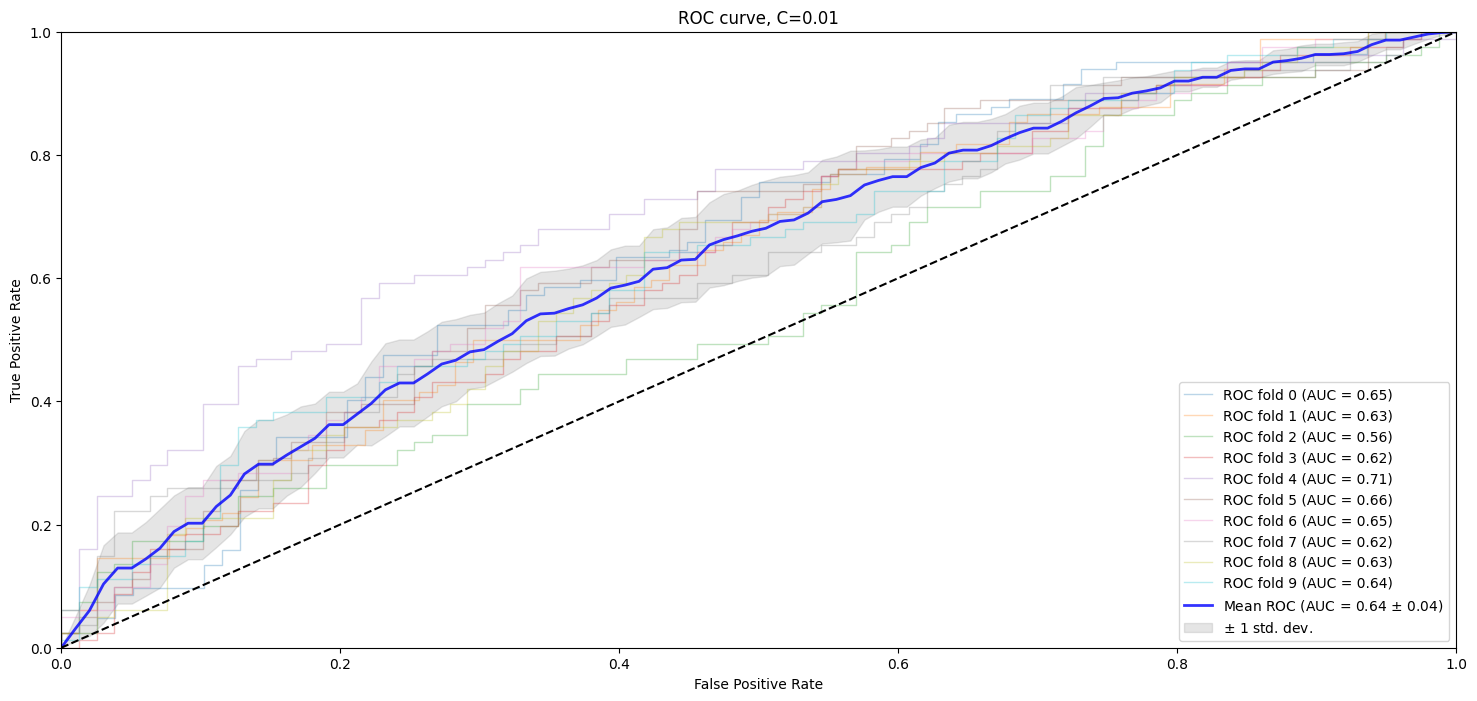

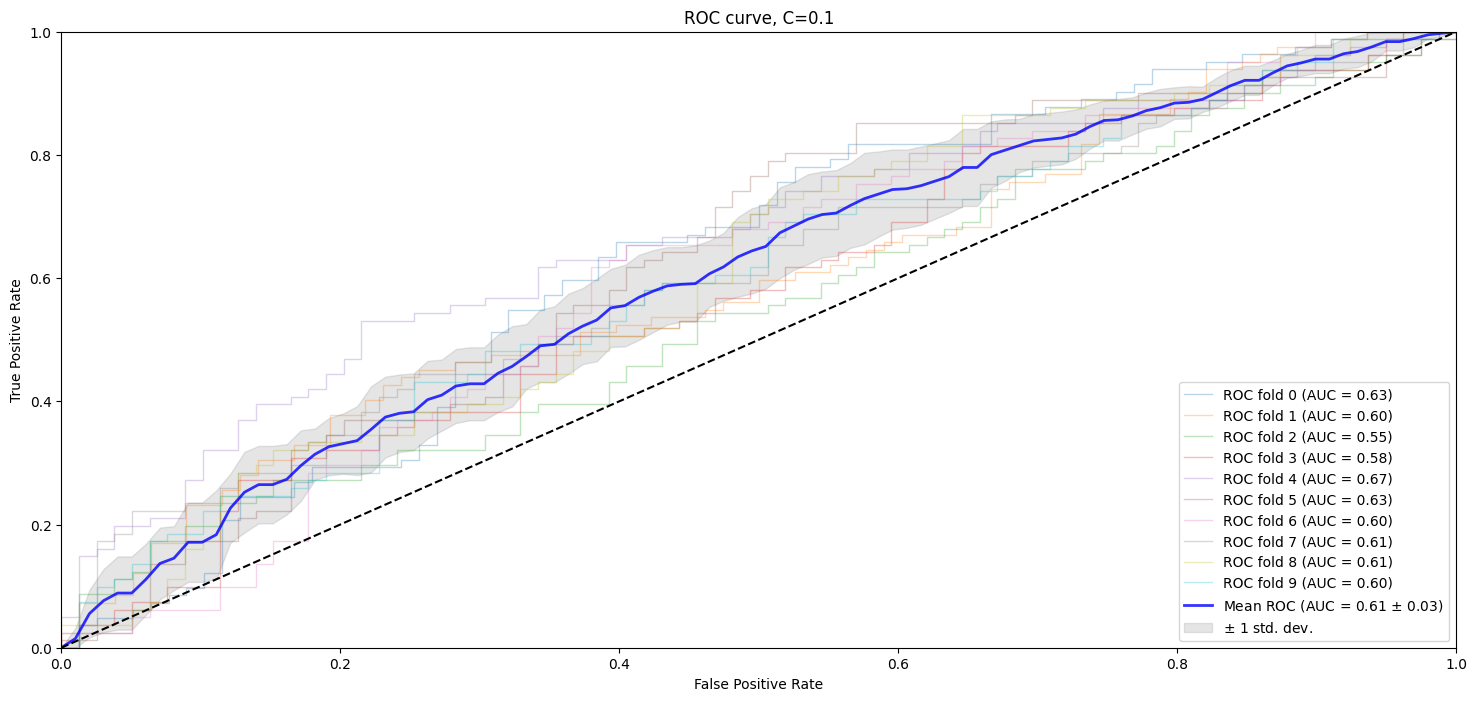

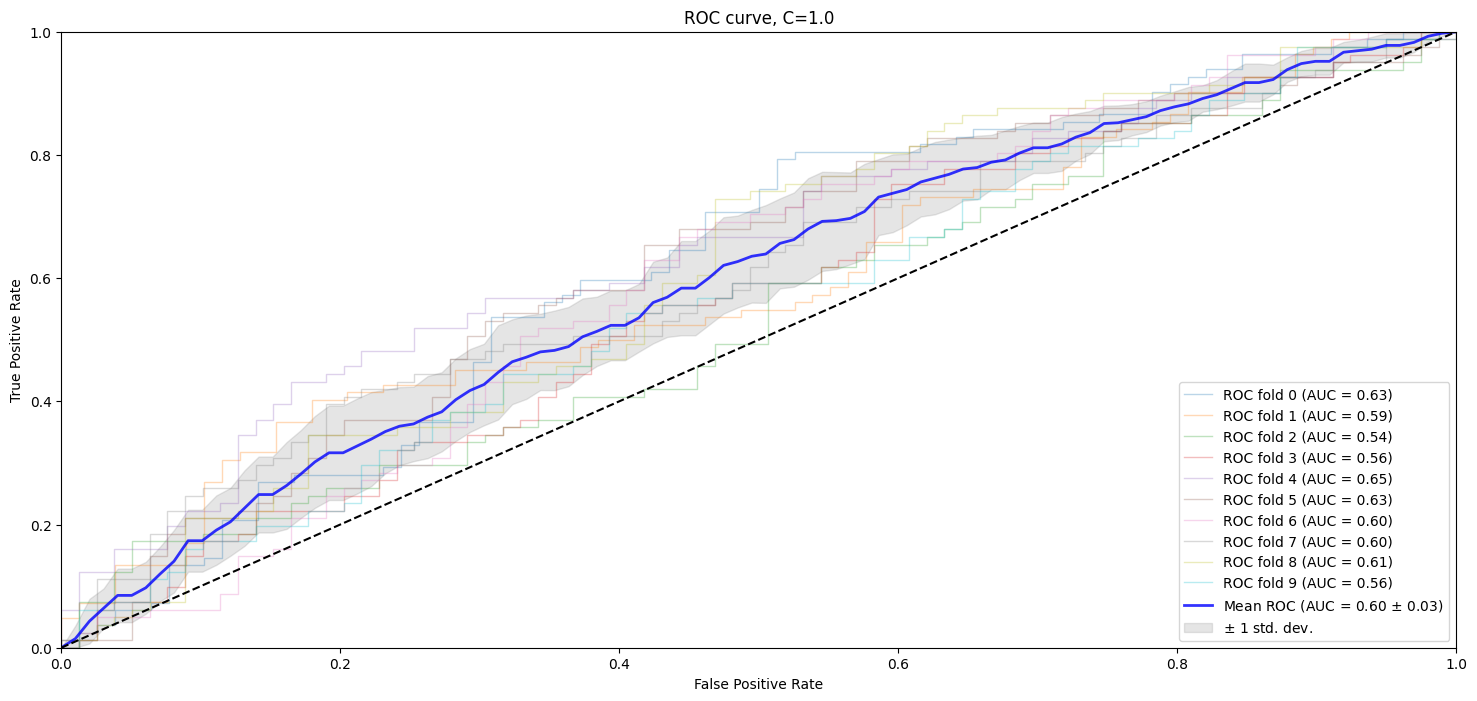

In [9]:
n_splits = 10
for c in np.logspace(-10,0,11):
    classifier = svm.SVC(C=c, kernel="linear")
    plot_roc_with_cv(classifier, X_train, Y_train, n_splits, f"ROC curve, C={c}")

## One-Hot Encoding

In [10]:
X_train = pd.get_dummies(raw_train.iloc[:, 0:200]).to_numpy()
Y_train = raw_train['label'].to_numpy()

X_test = pd.get_dummies(raw_test.iloc[:, 0:200]).to_numpy()
Y_test = raw_test['label'].to_numpy()
# print(X_train)

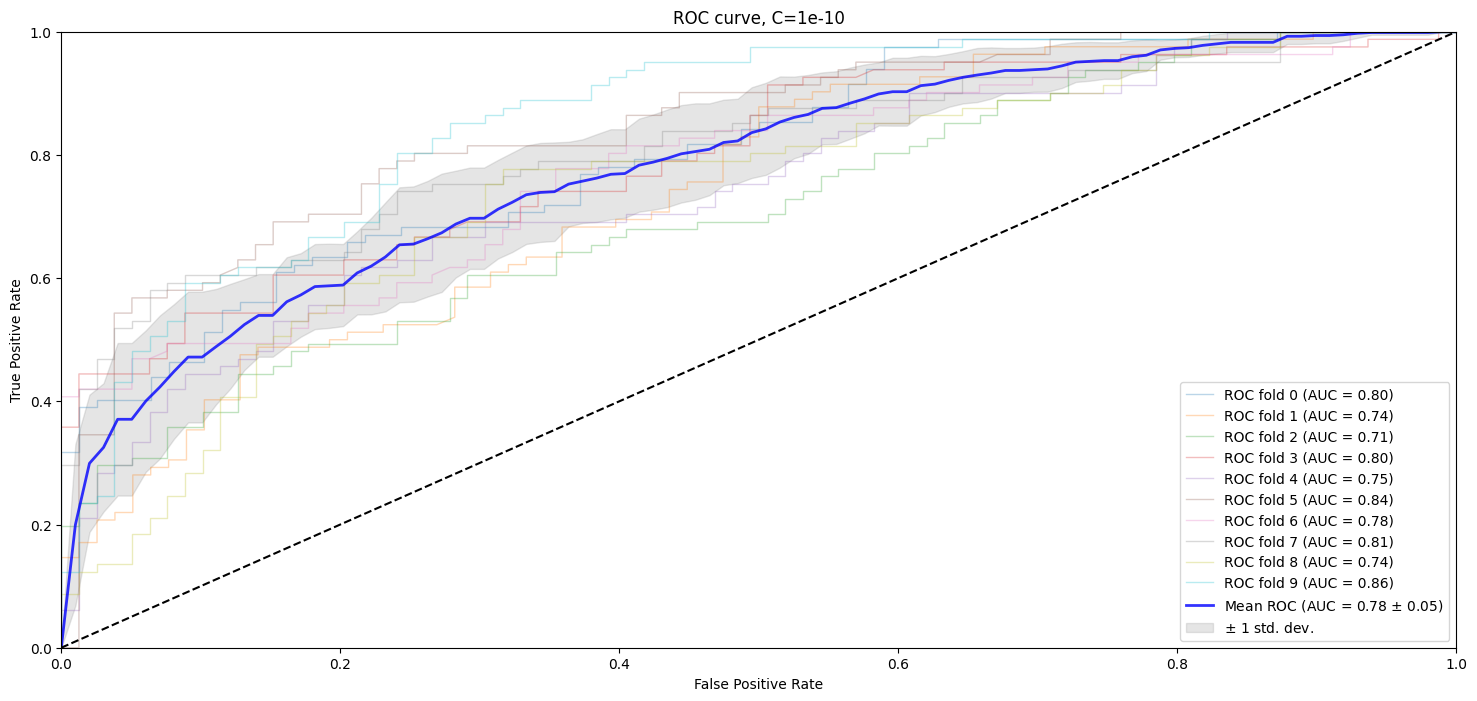

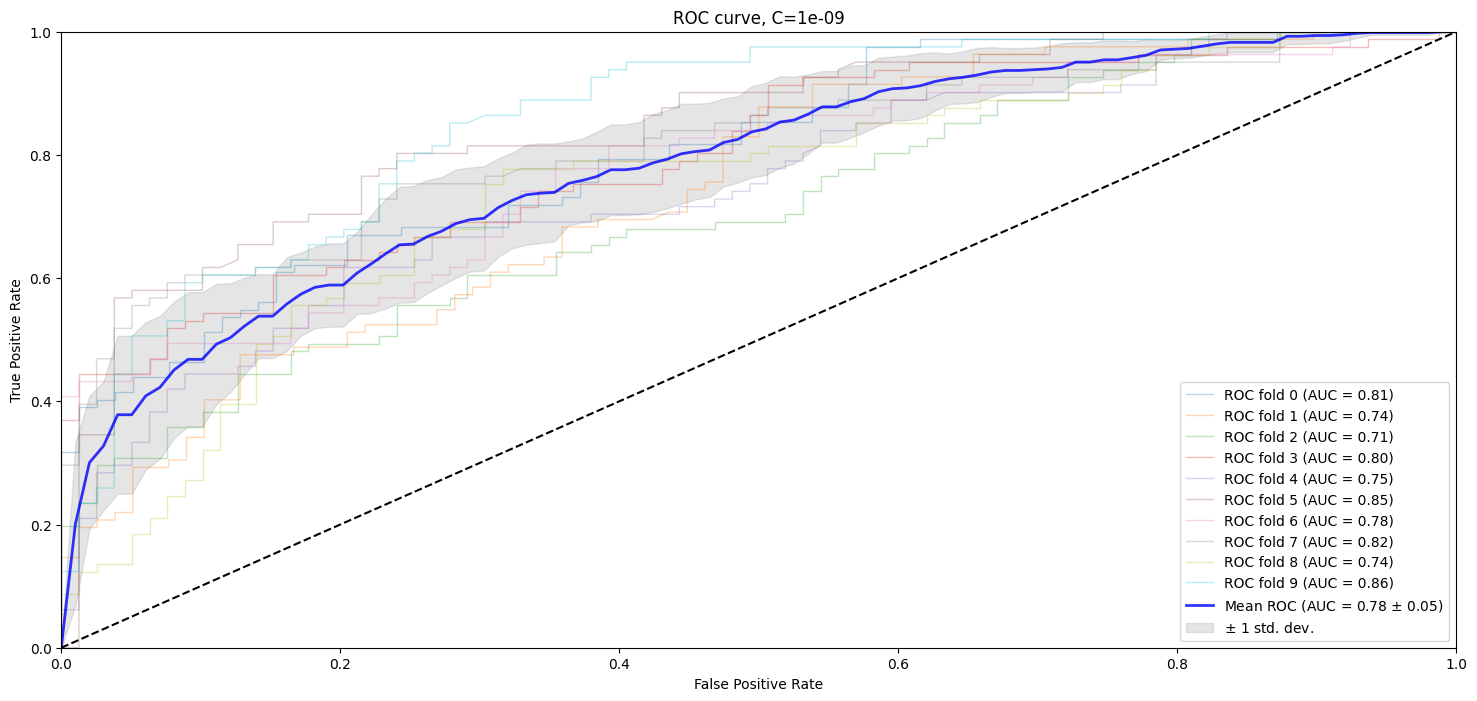

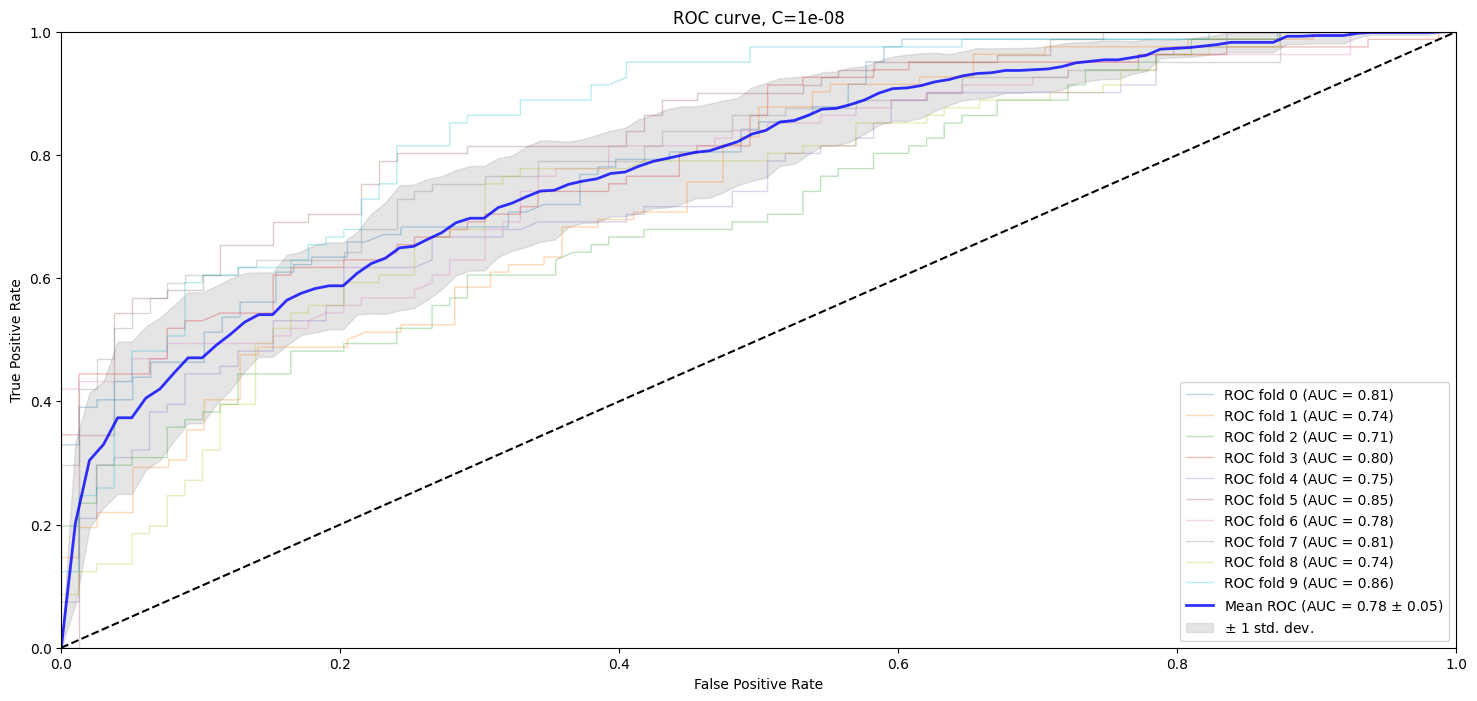

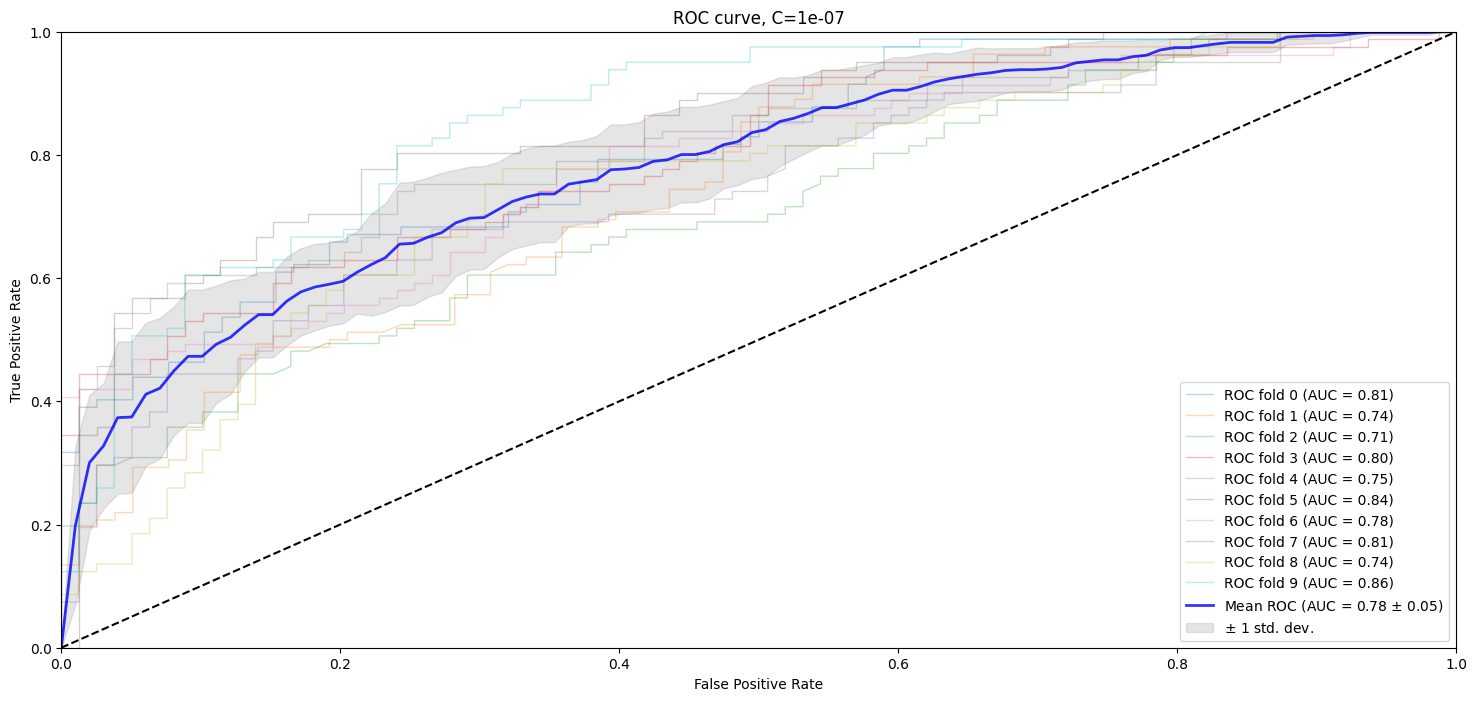

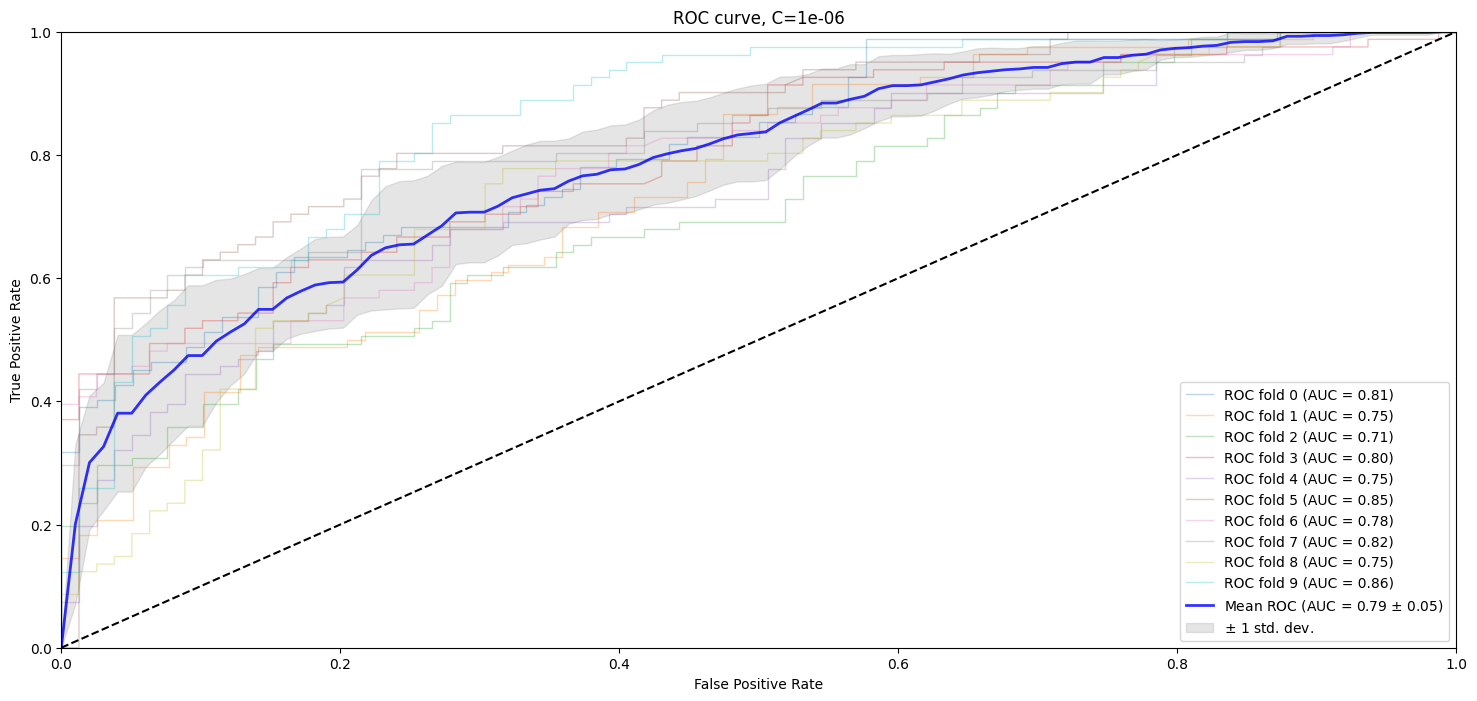

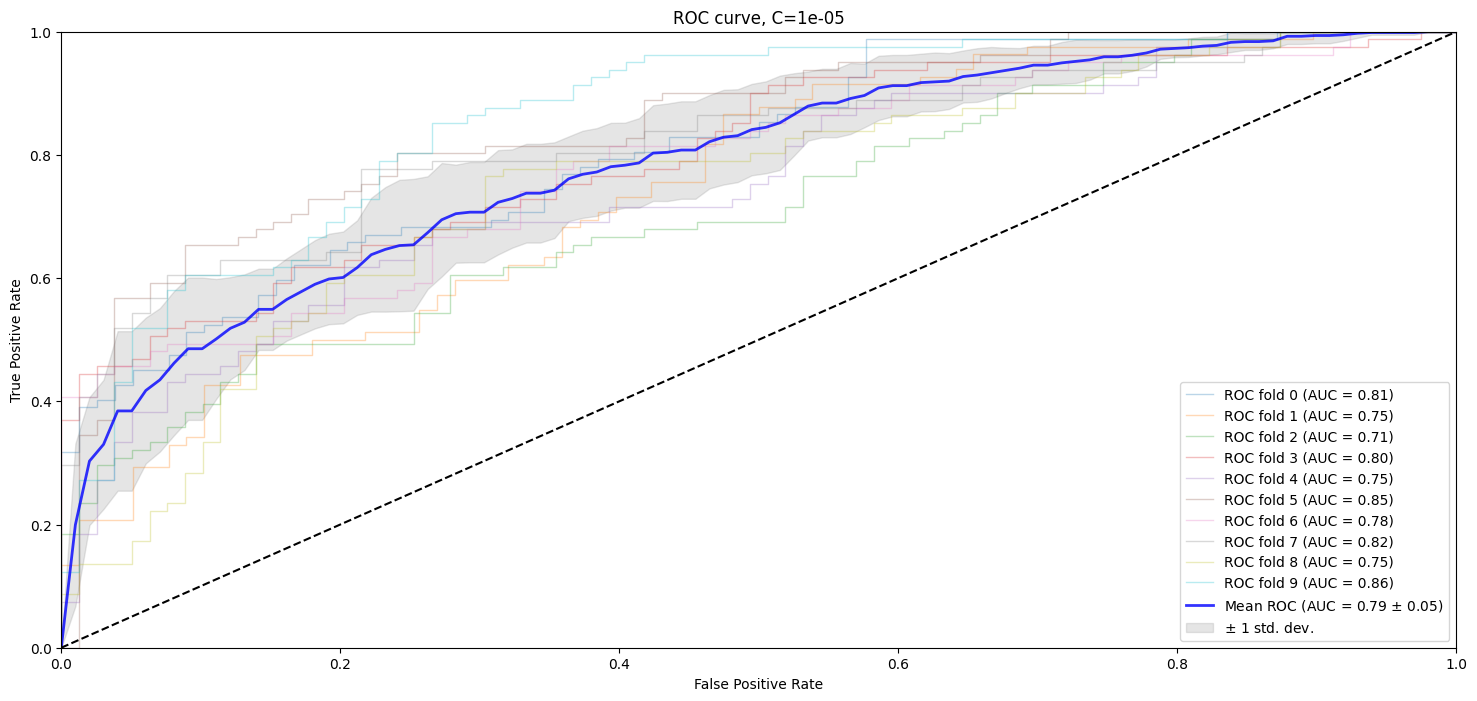

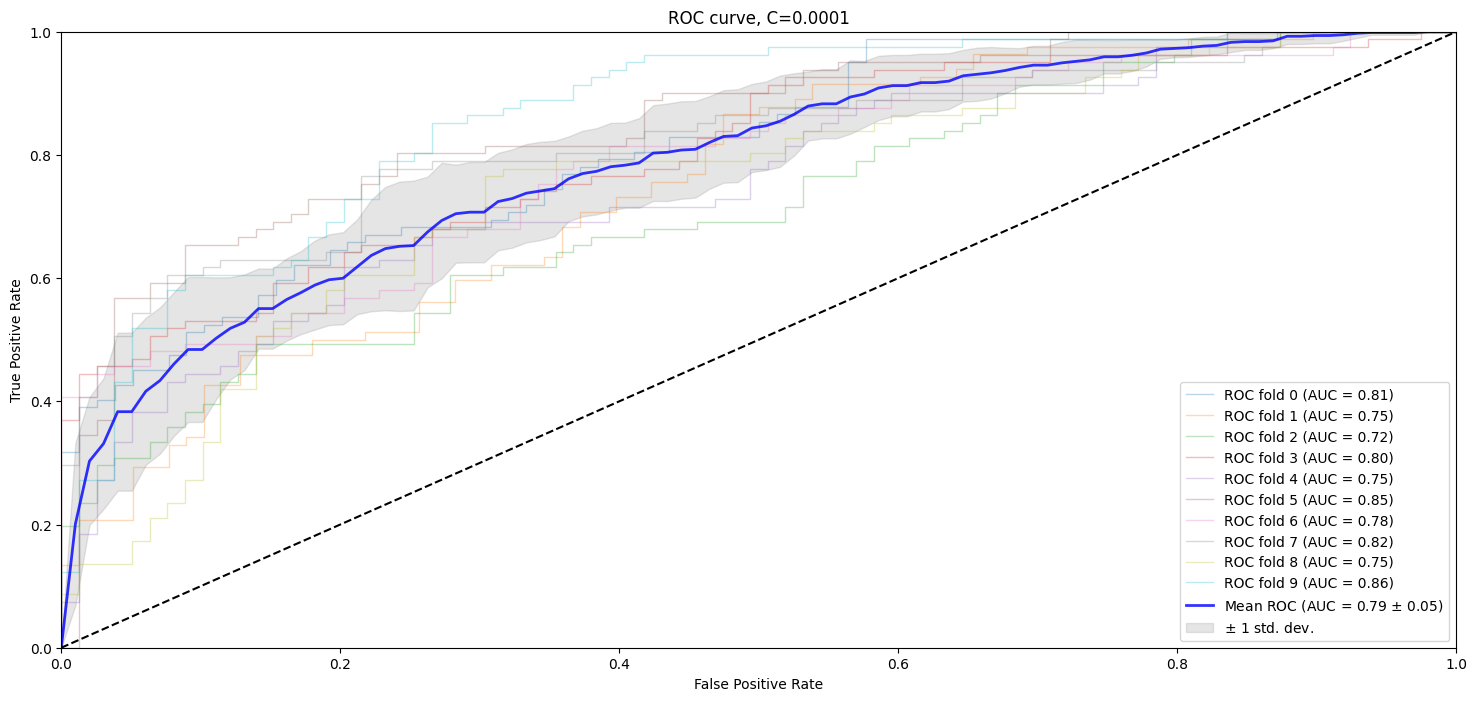

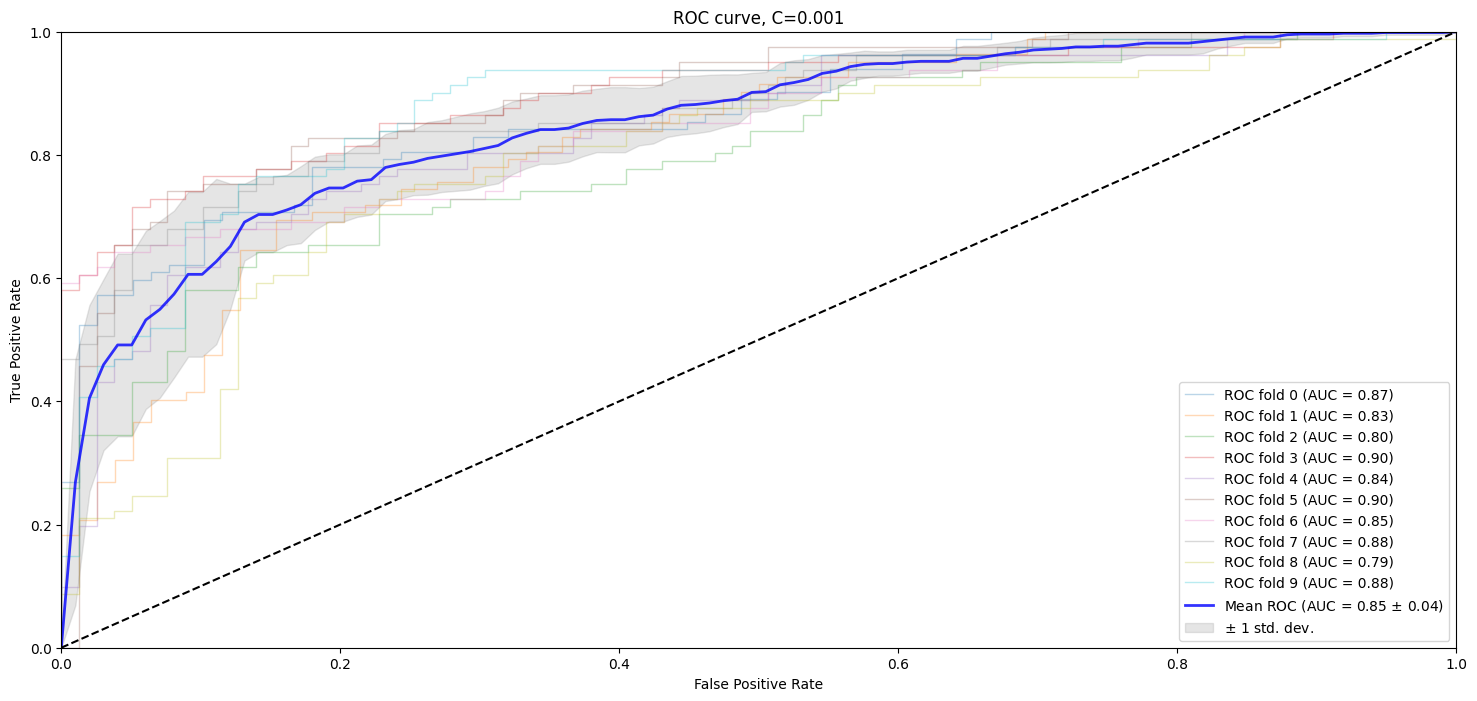

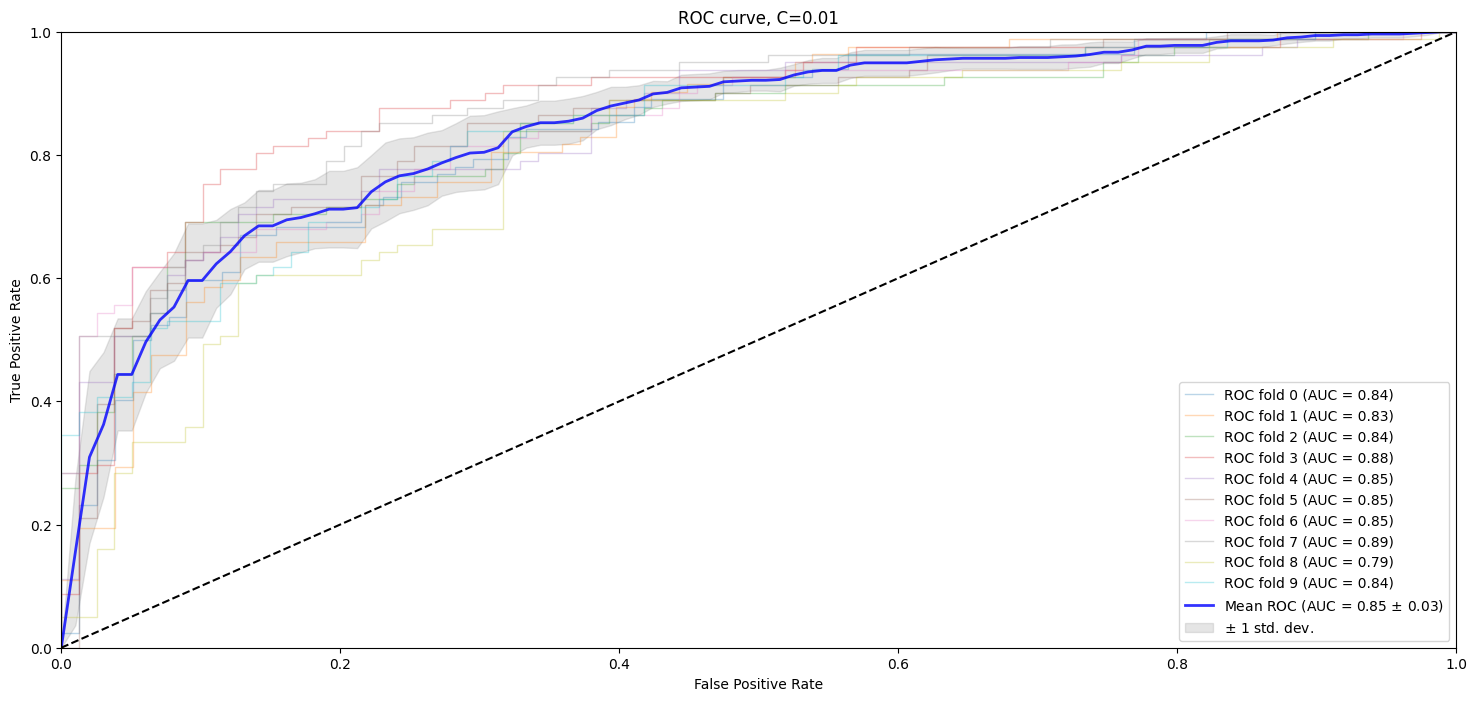

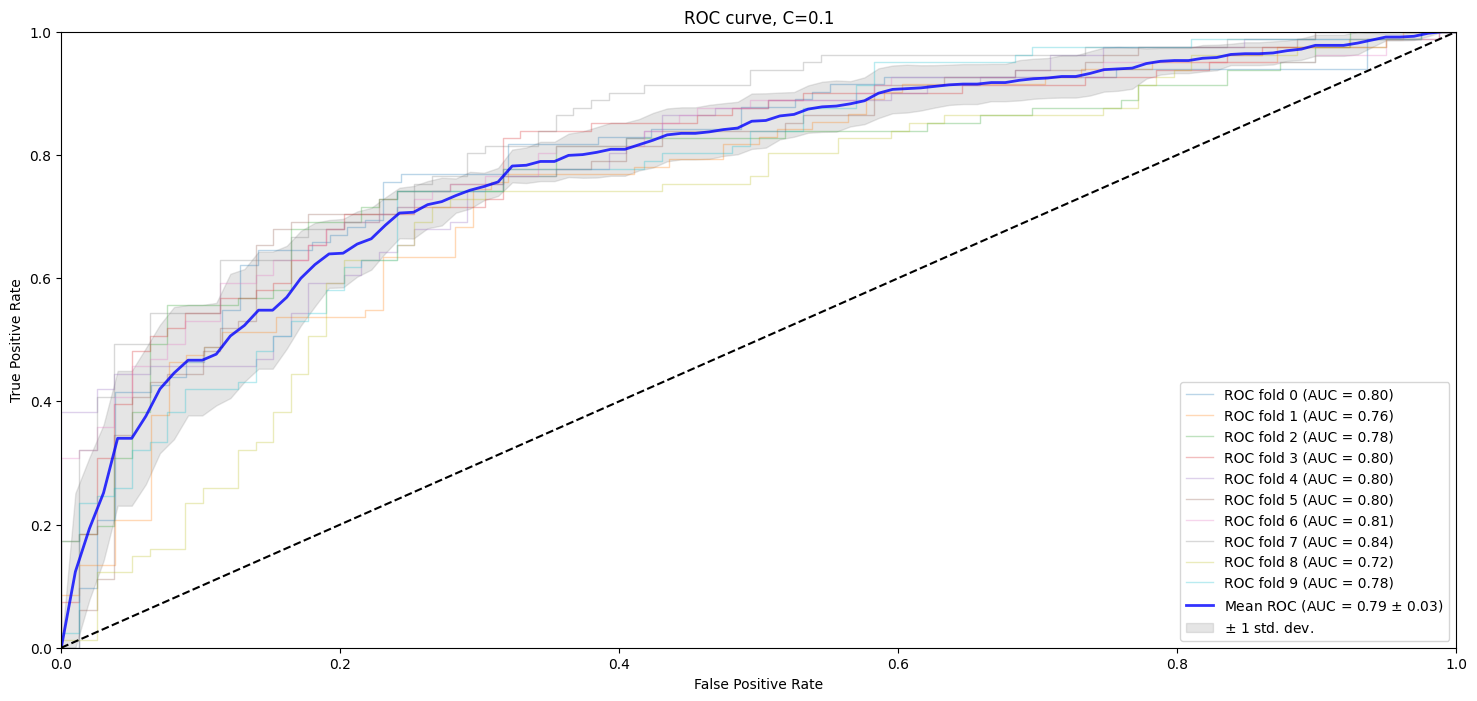

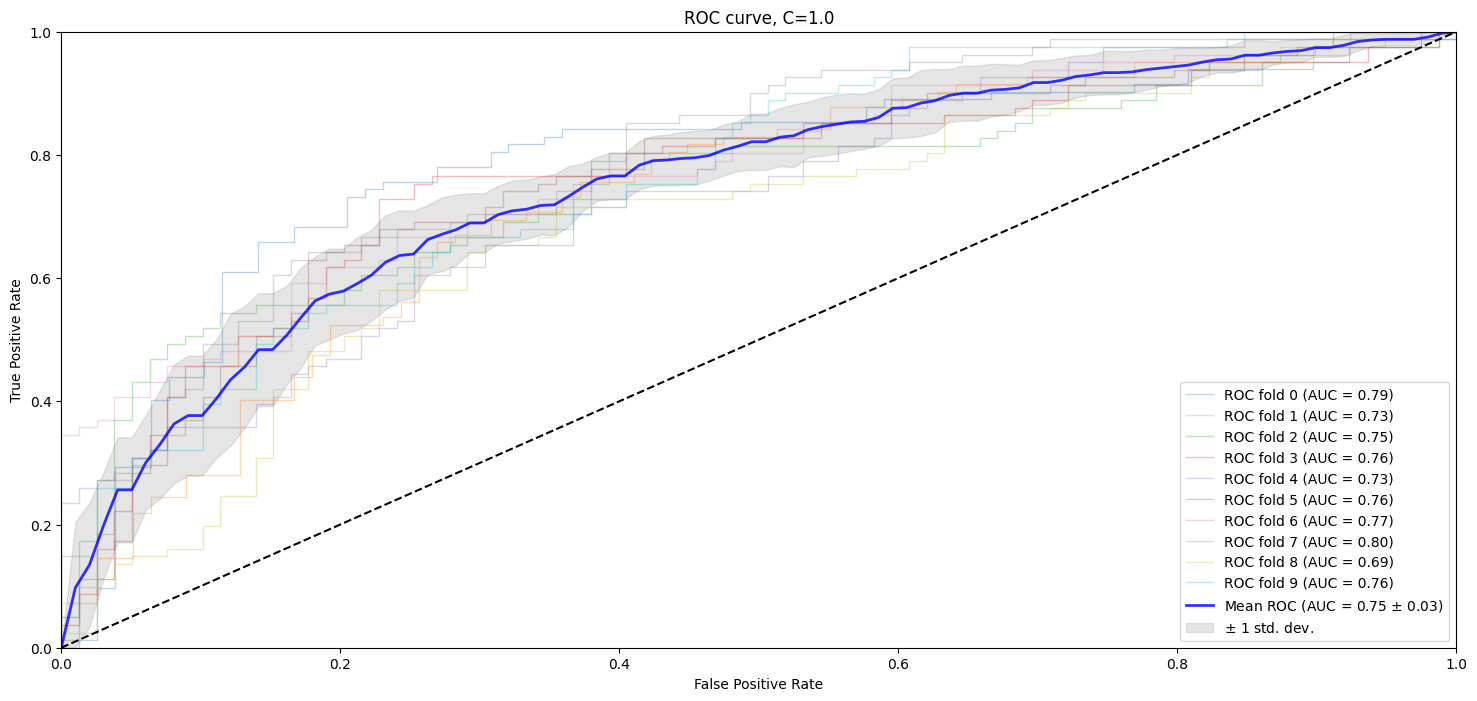

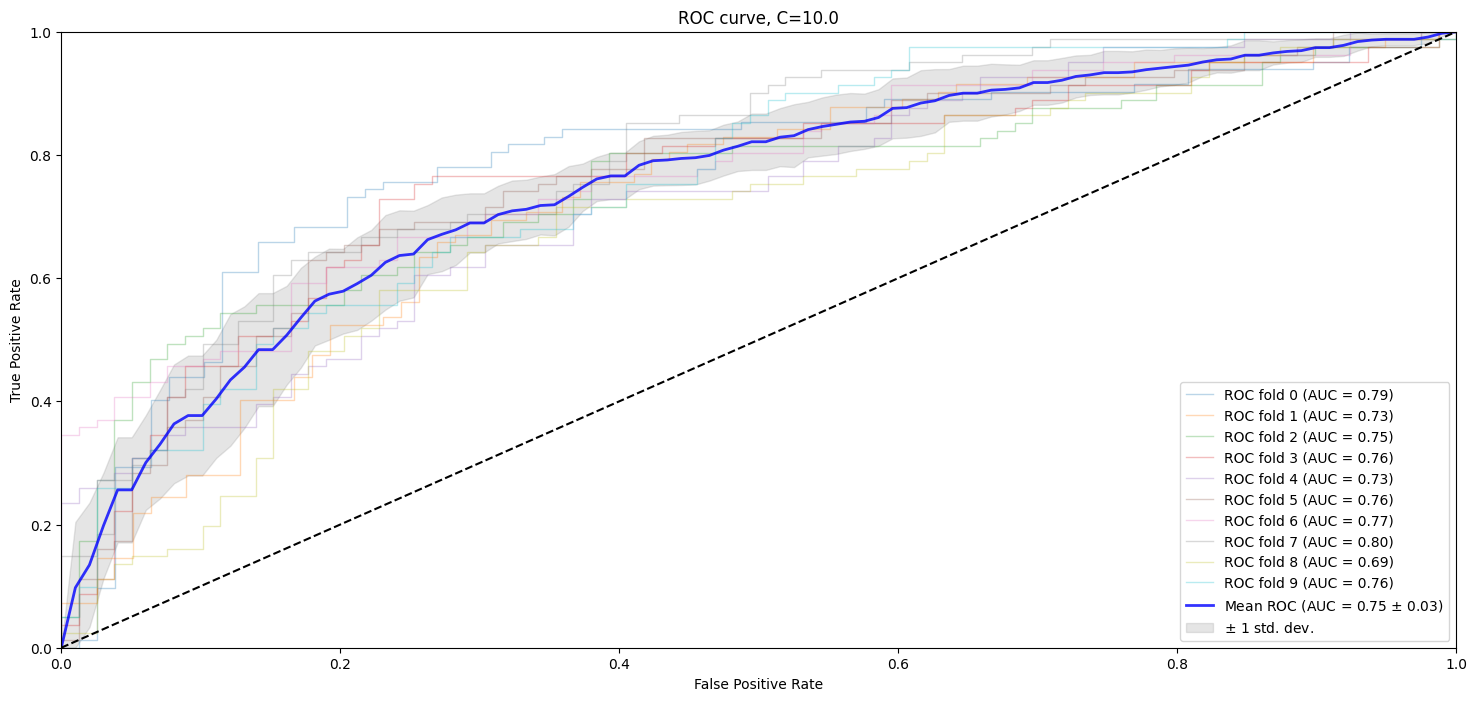

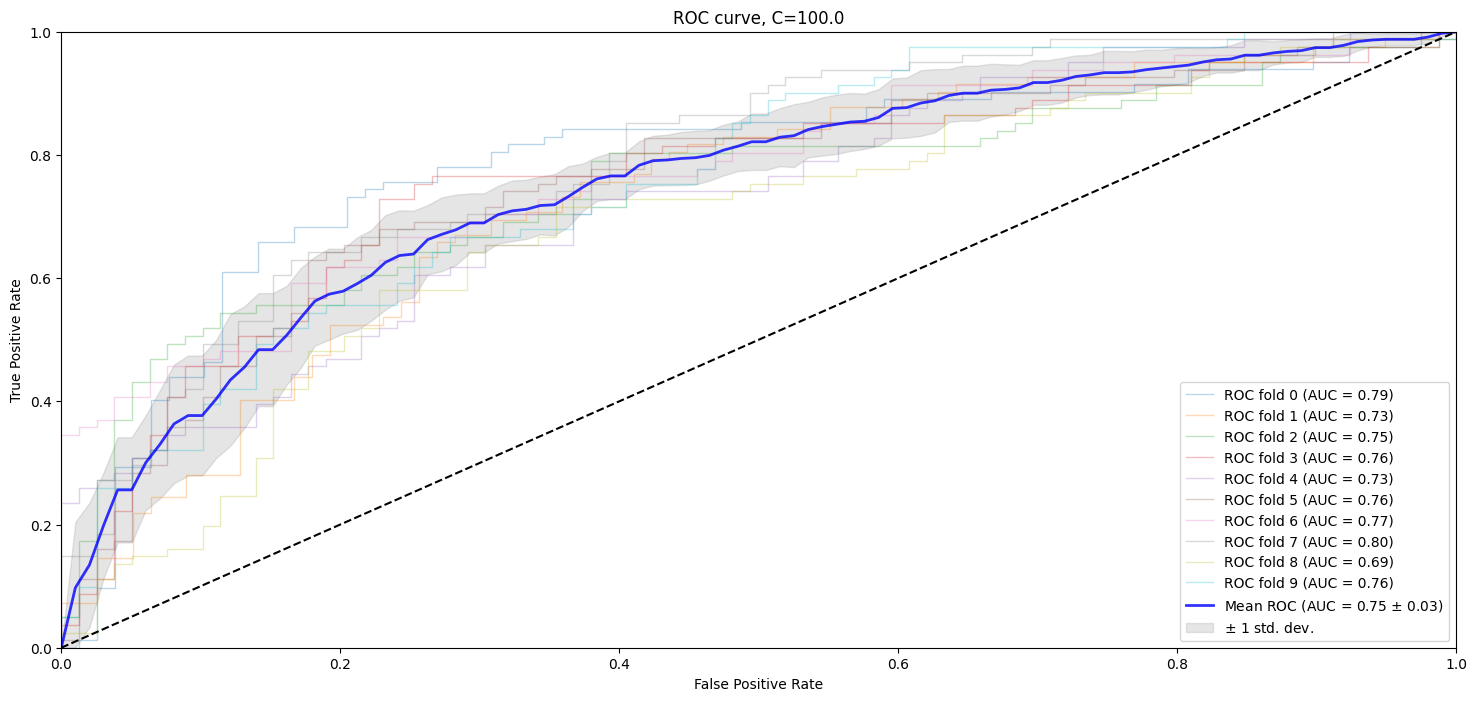

In [11]:
n_splits = 10
for c in np.logspace(-10,2,13):
    classifier = svm.SVC(C=c, kernel="linear")
    plot_roc_with_cv(classifier, X_train, Y_train, n_splits, f"ROC curve, C={c}")

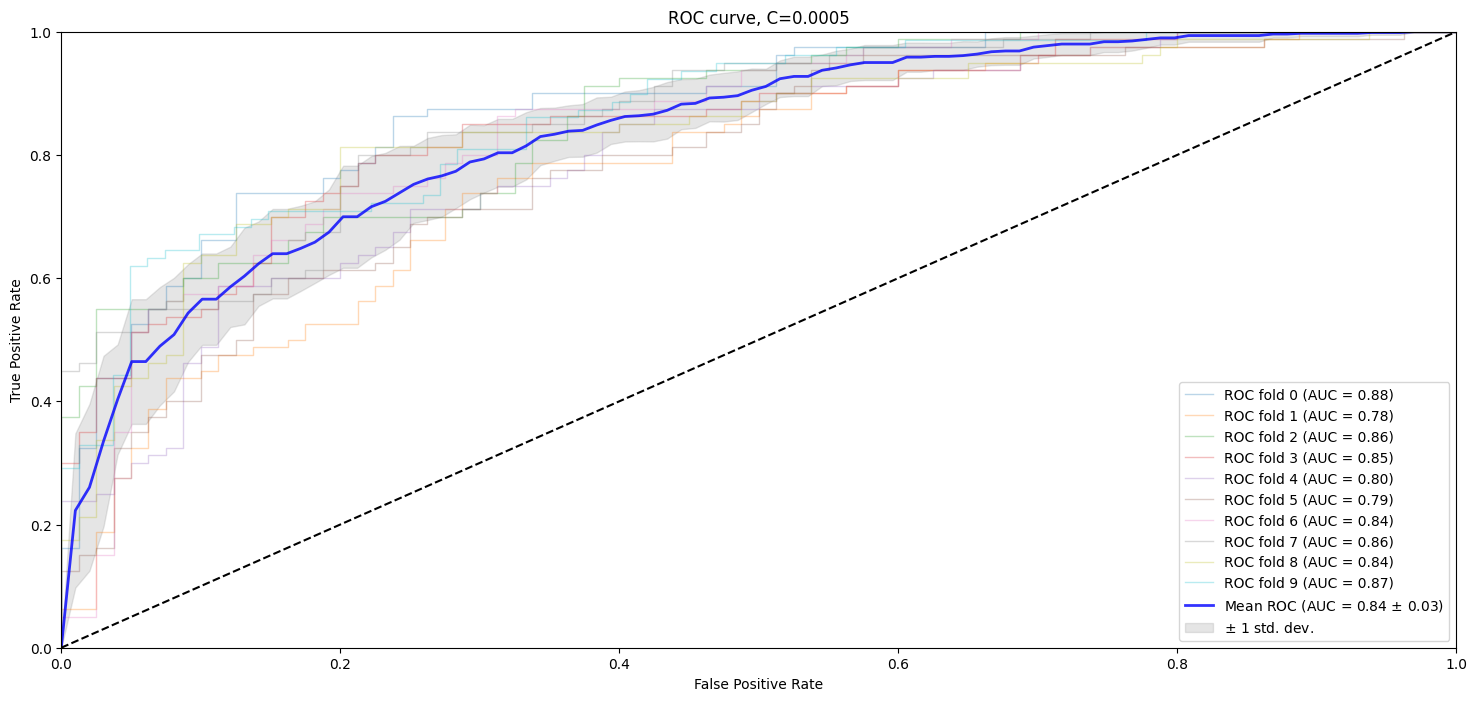

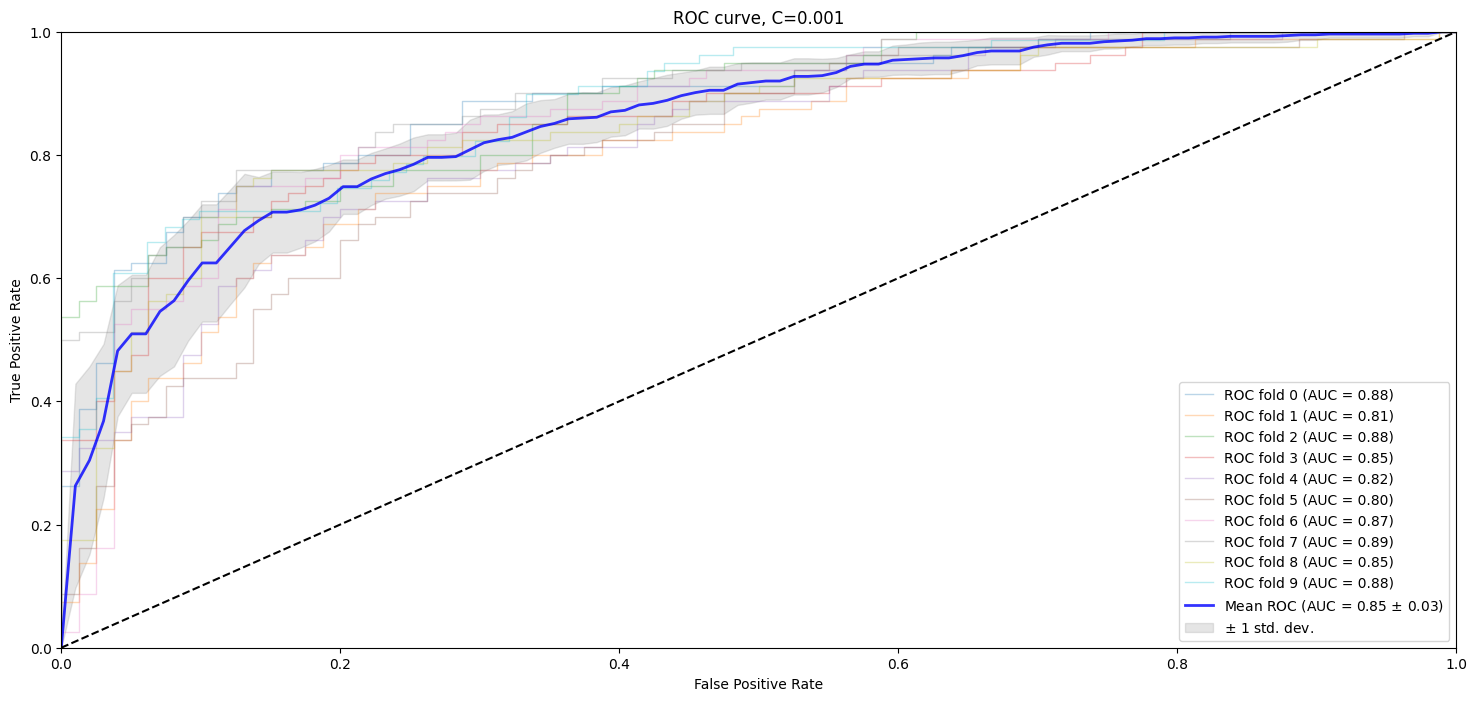

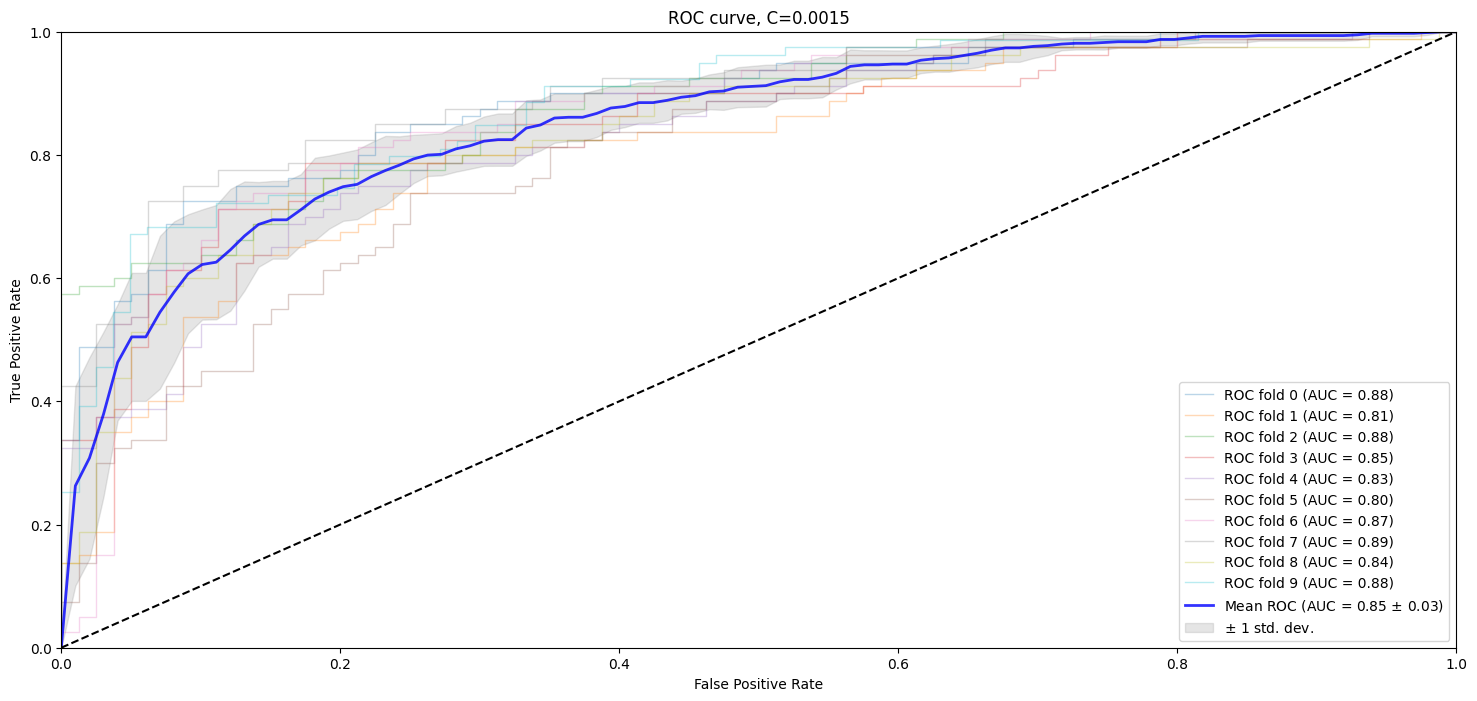

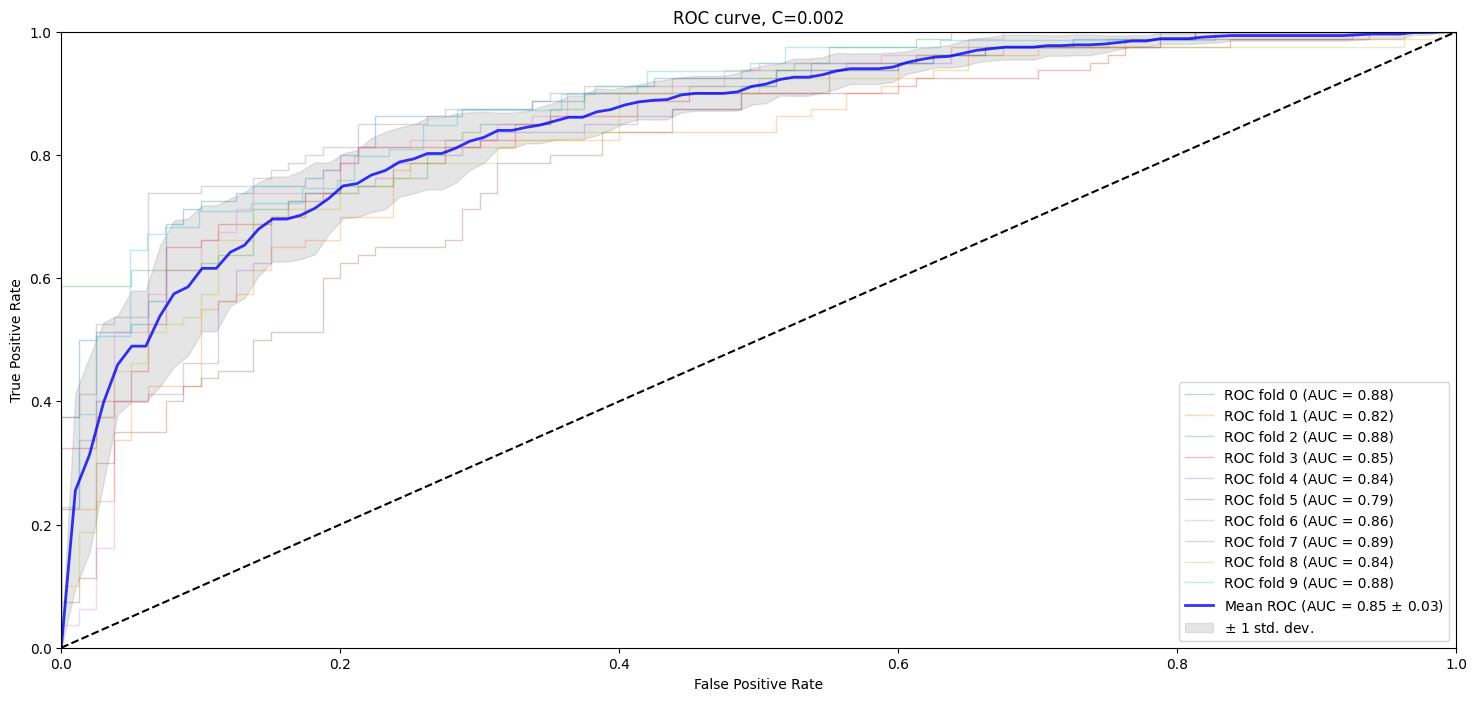

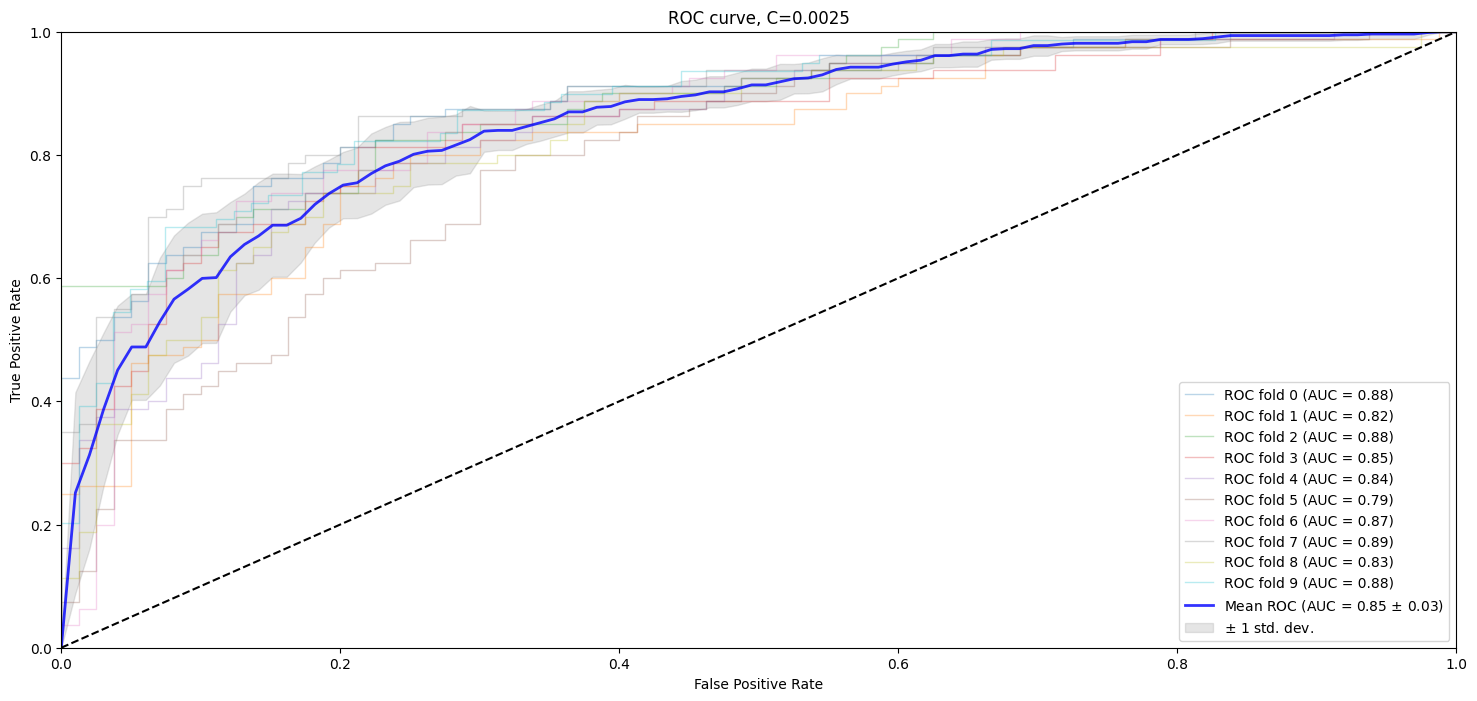

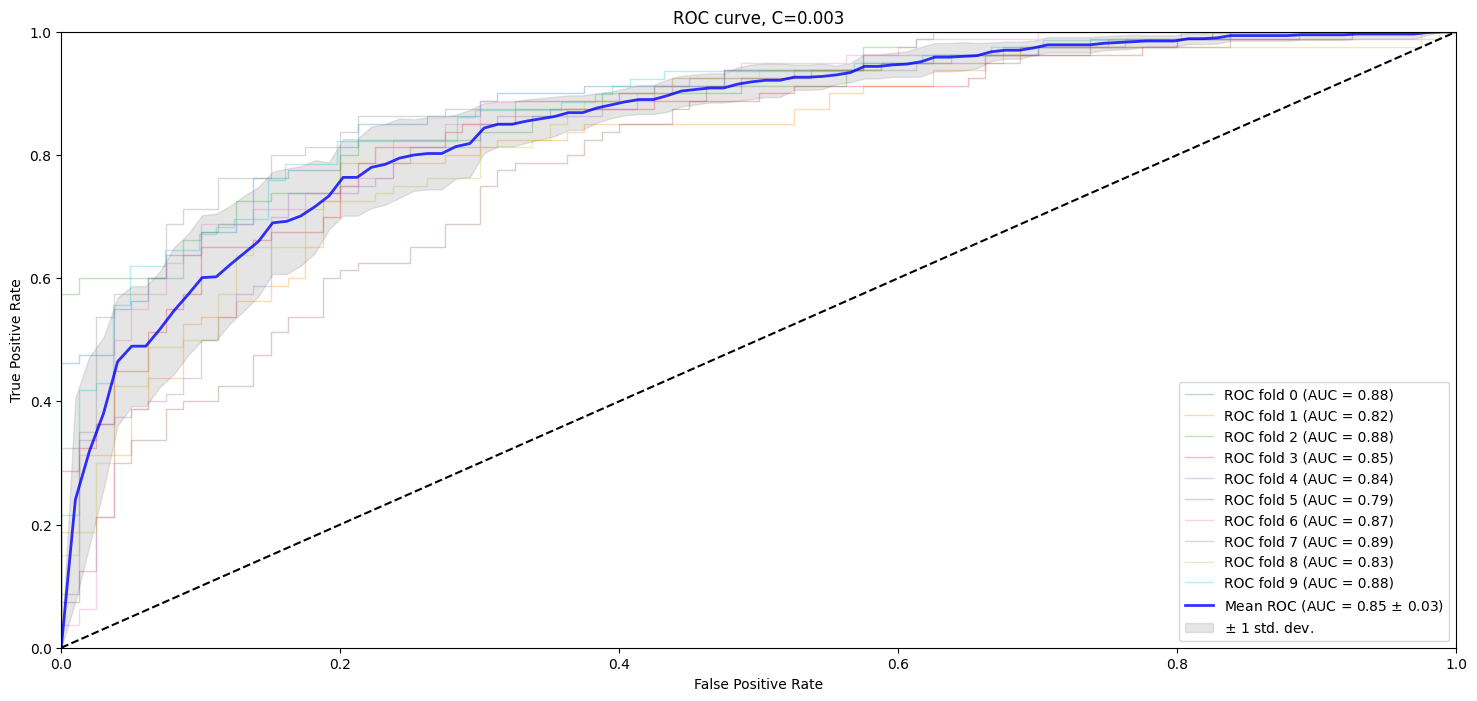

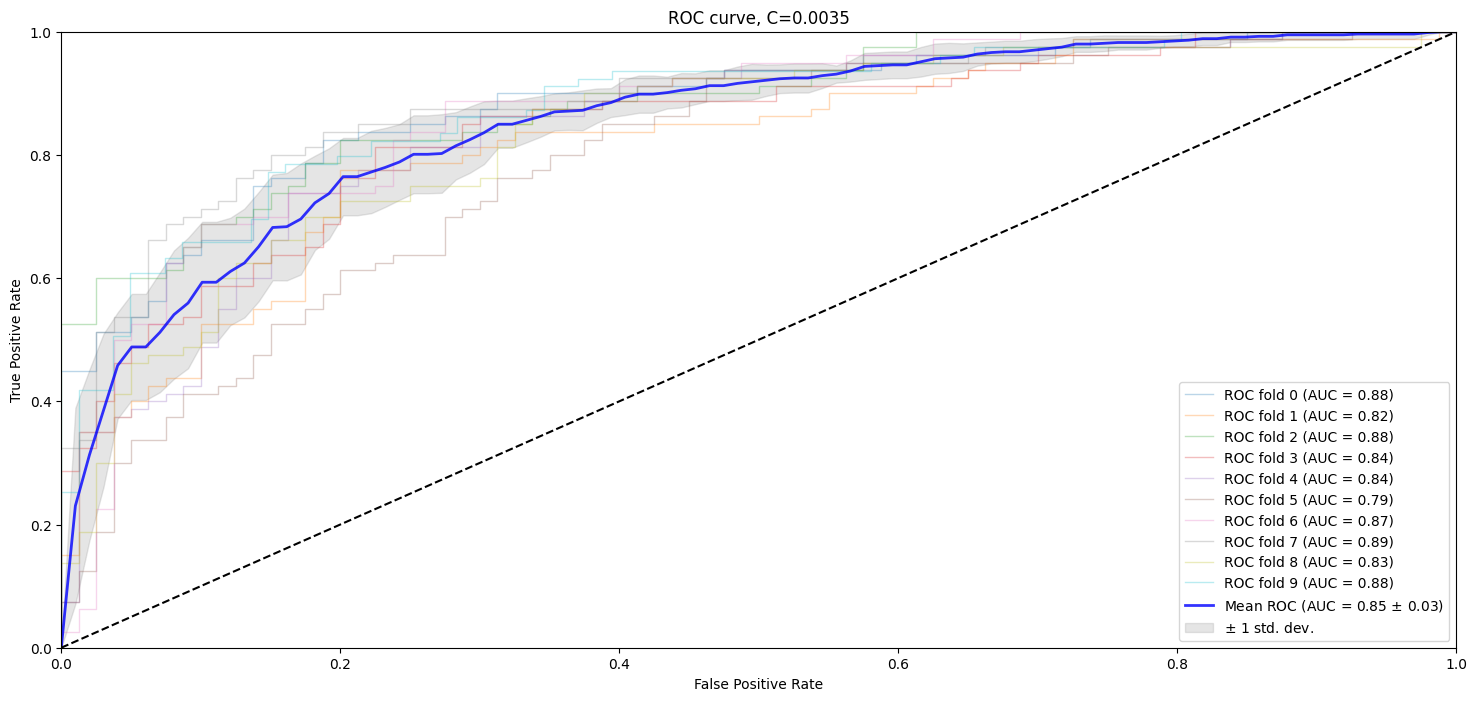

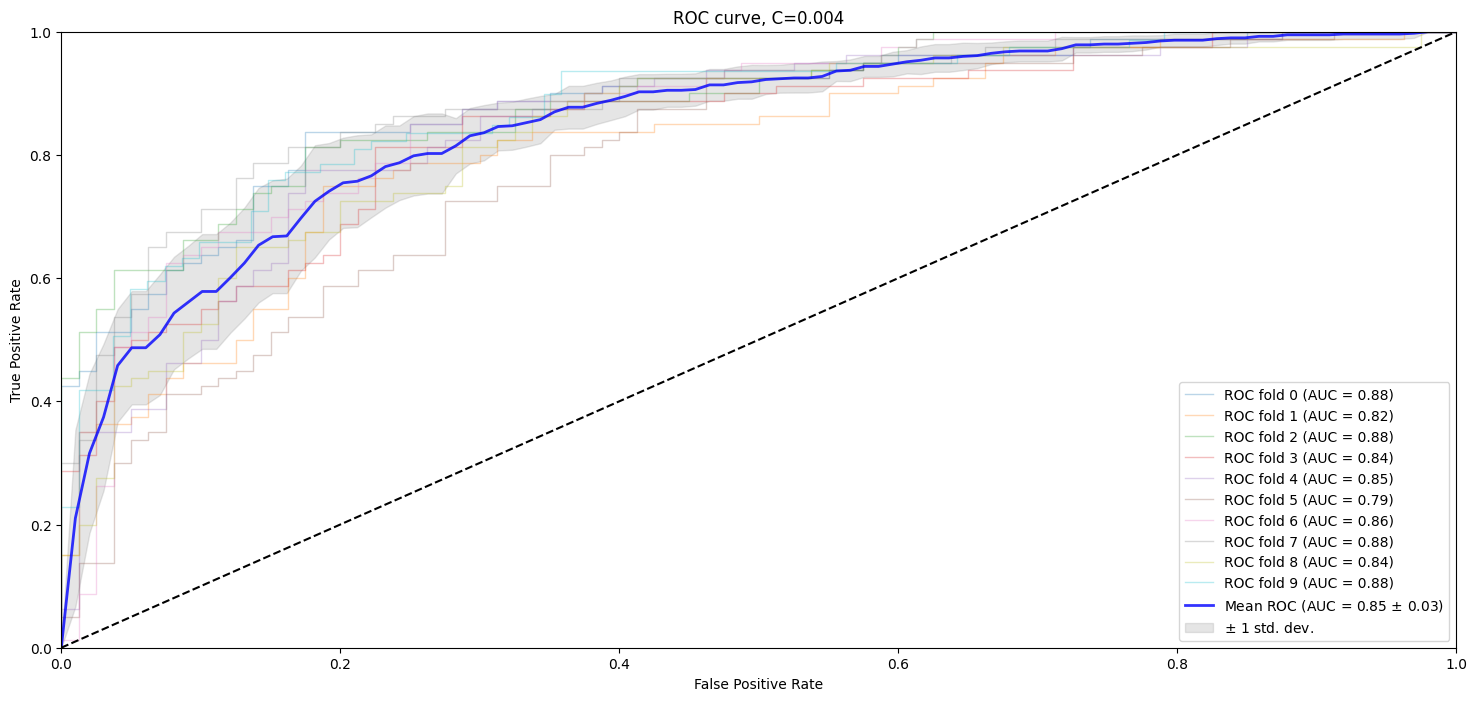

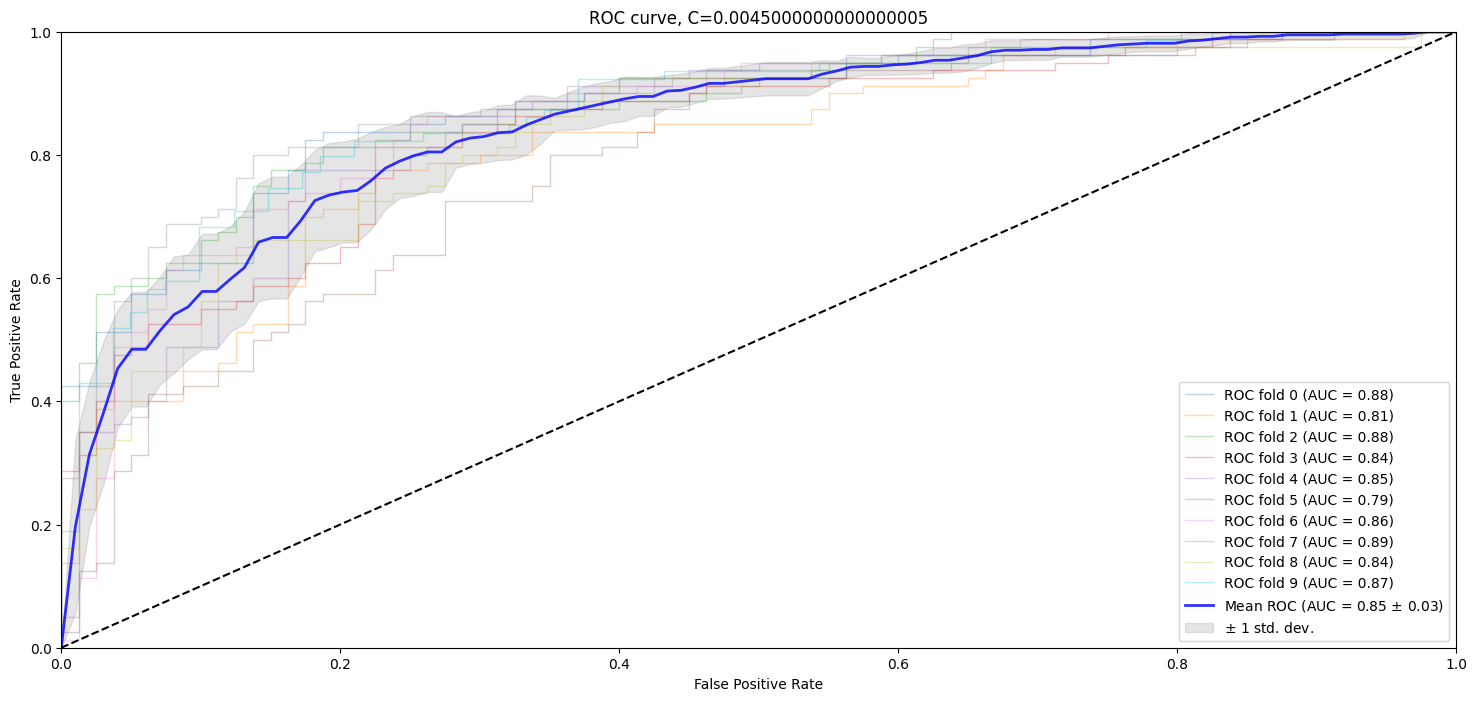

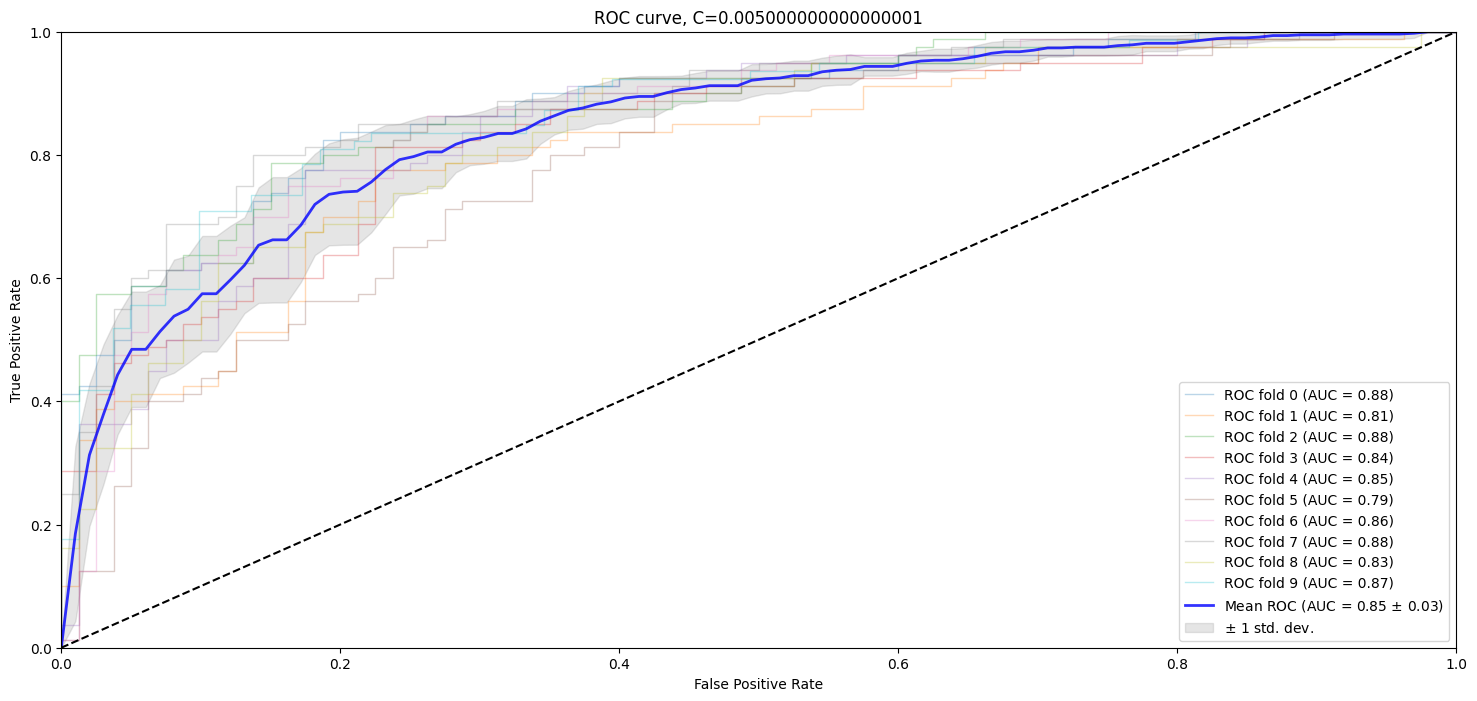

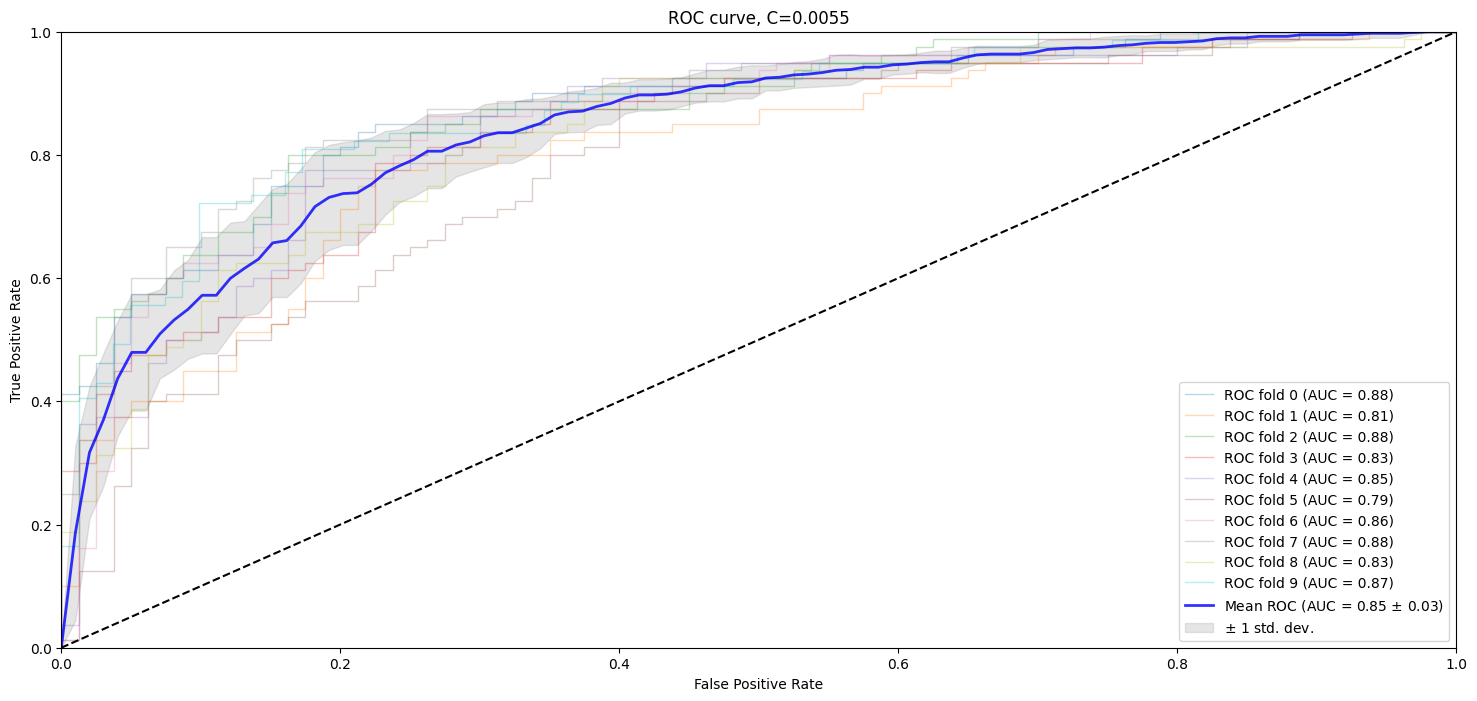

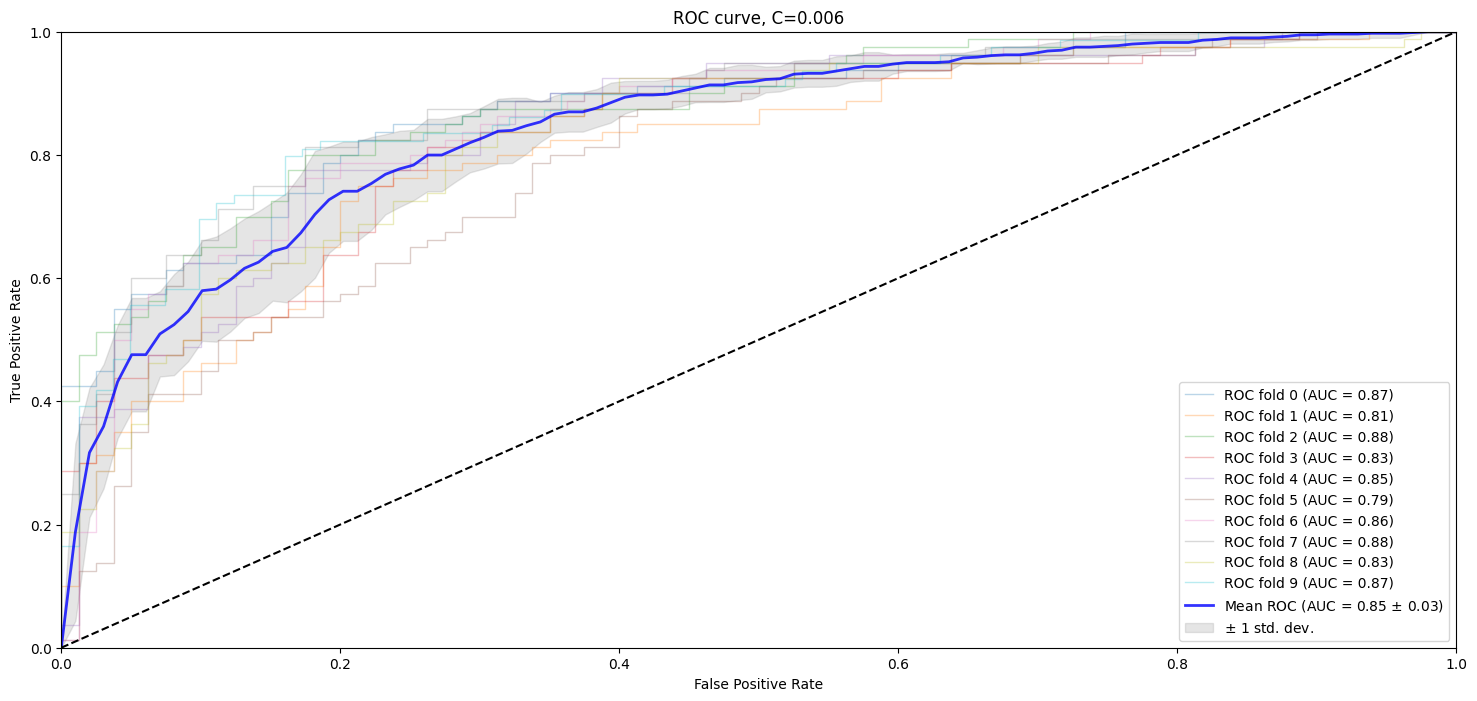

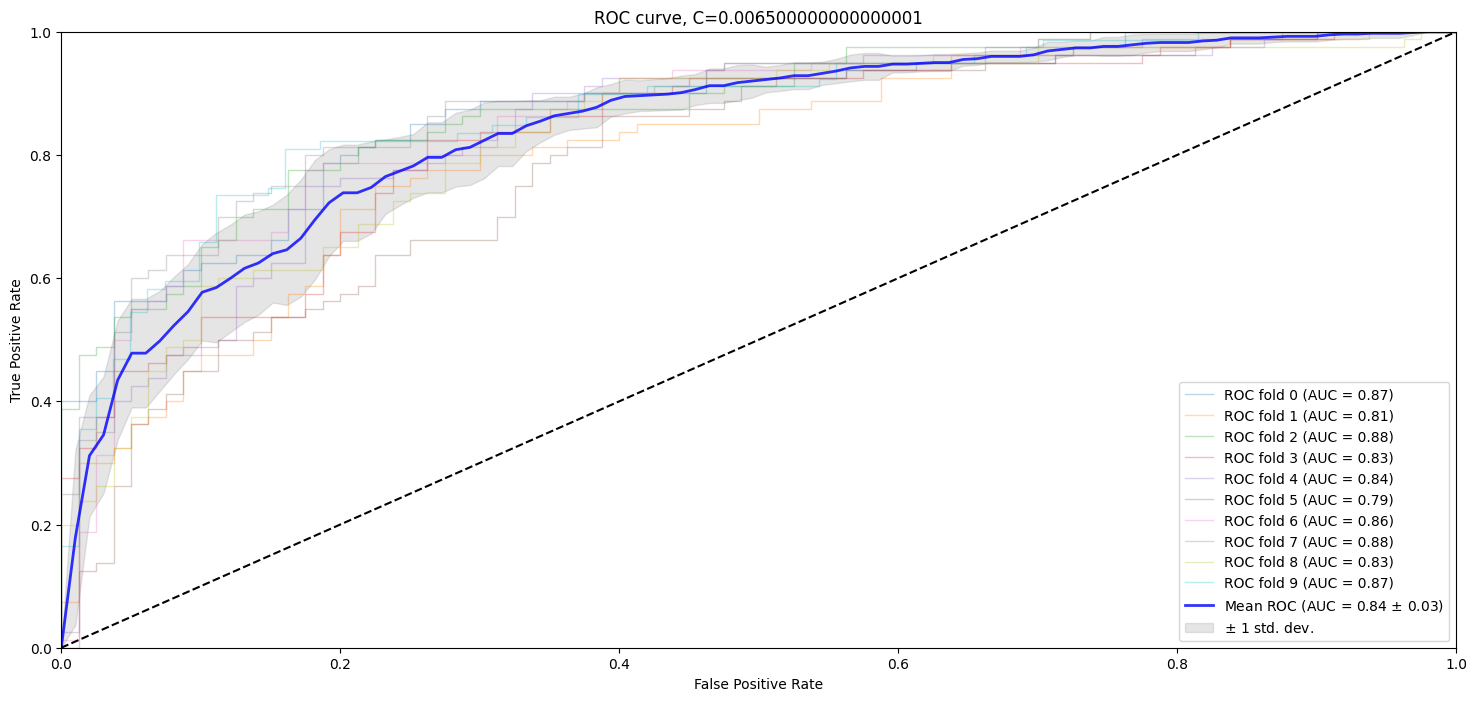

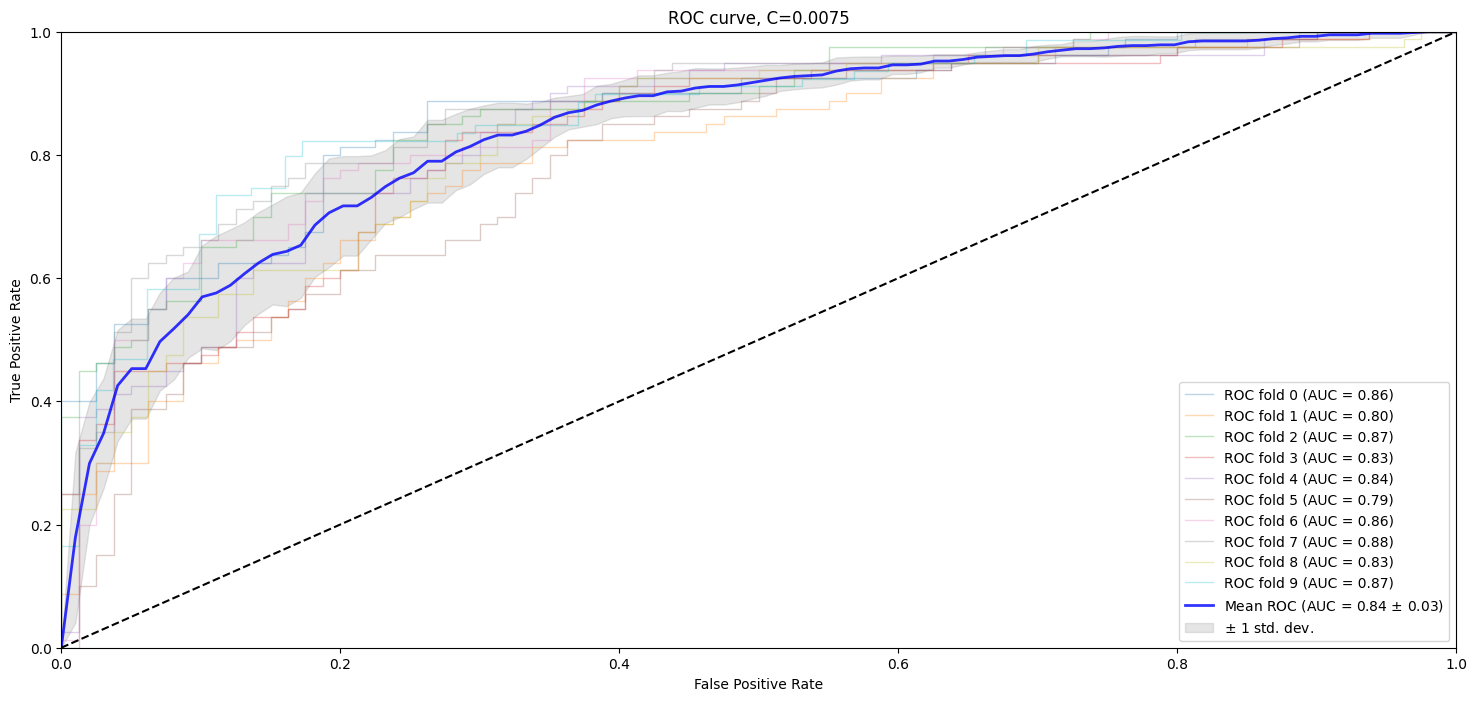

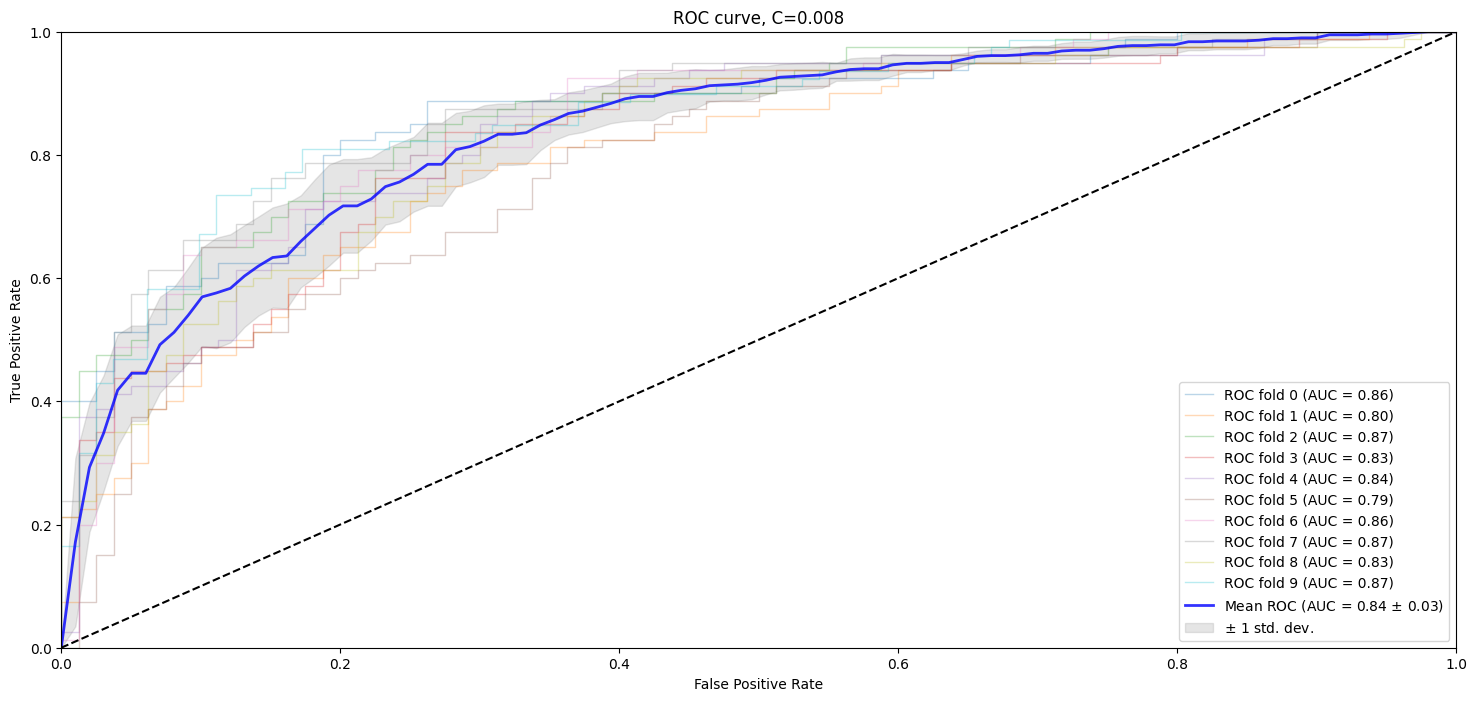

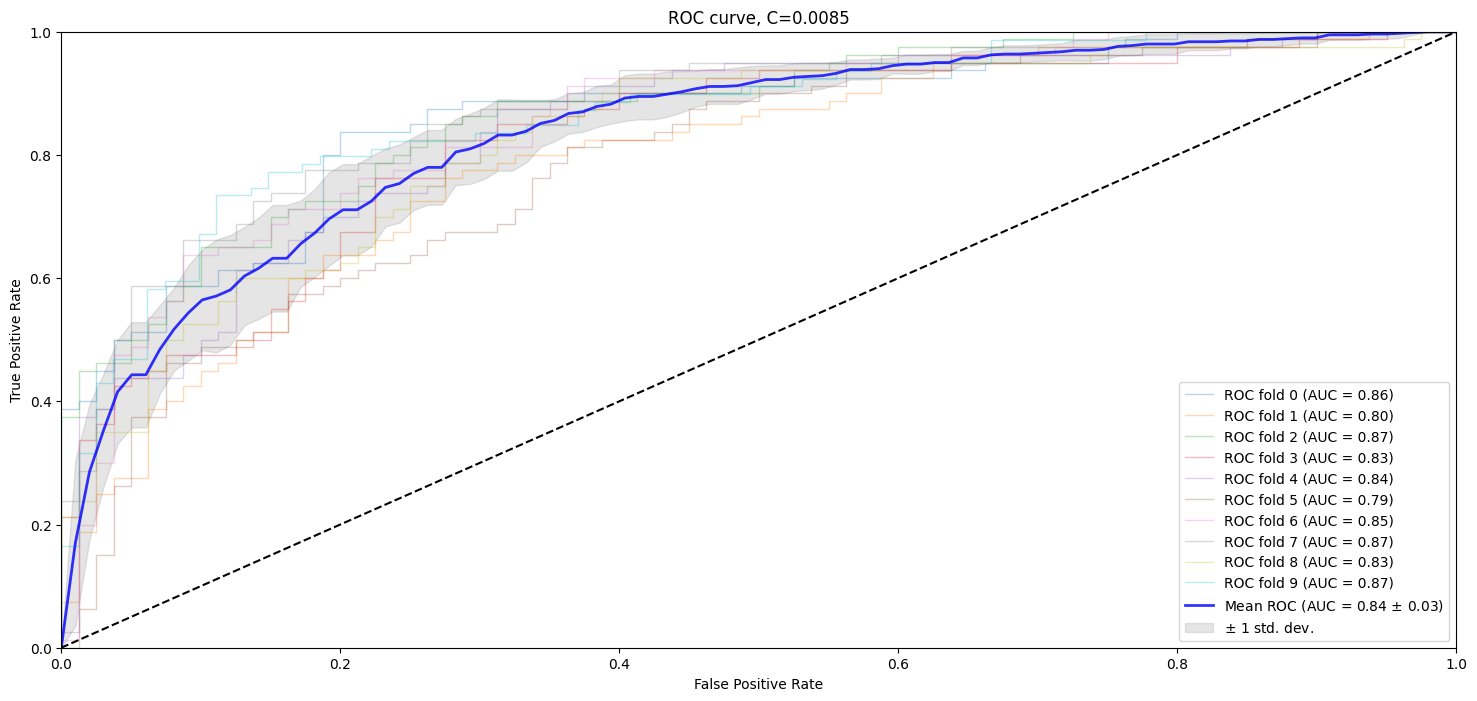

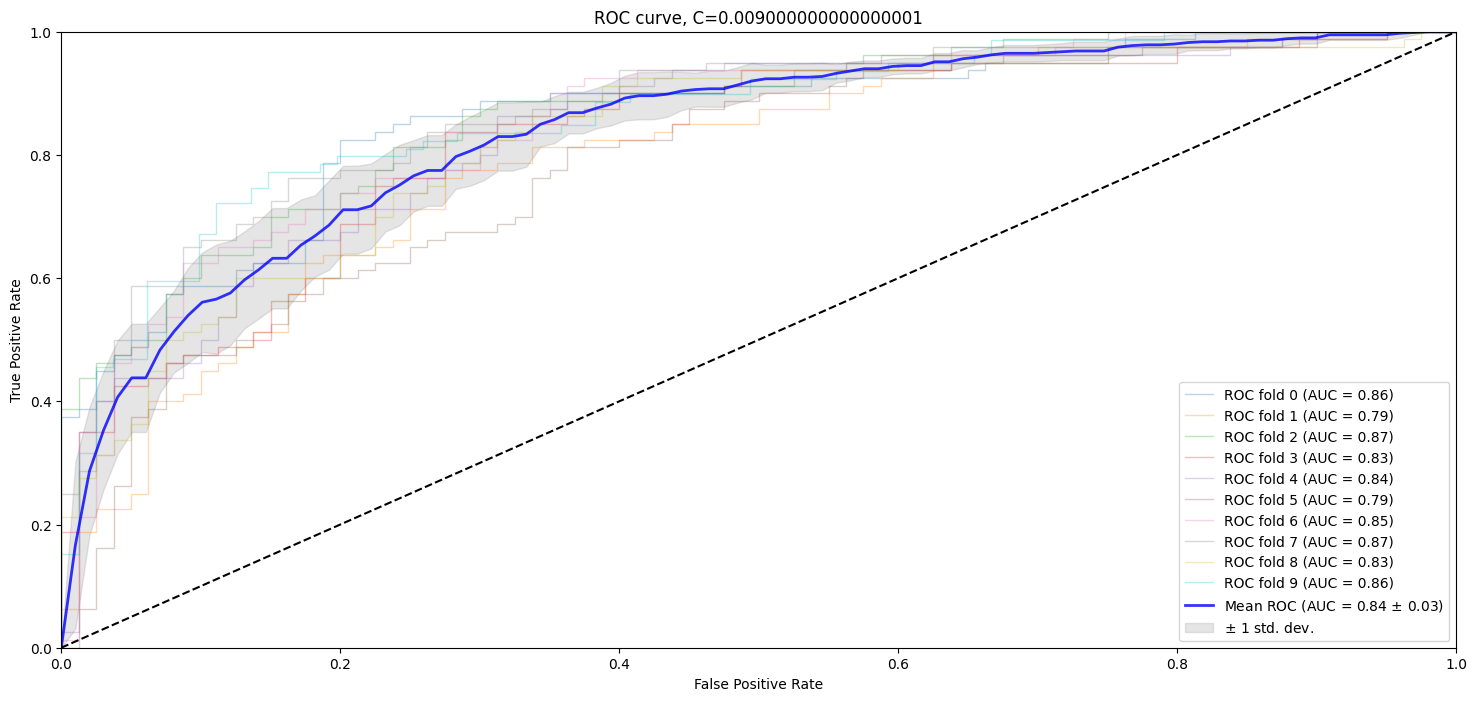

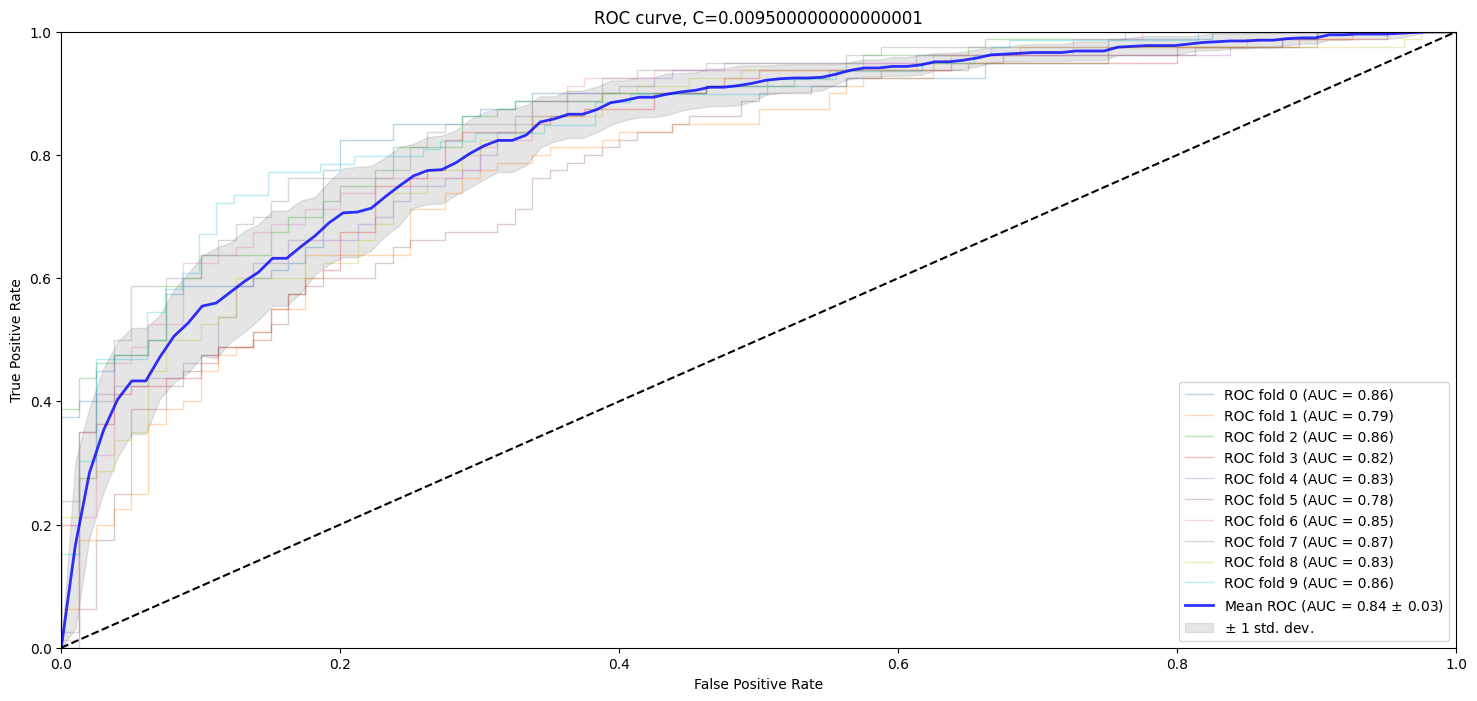

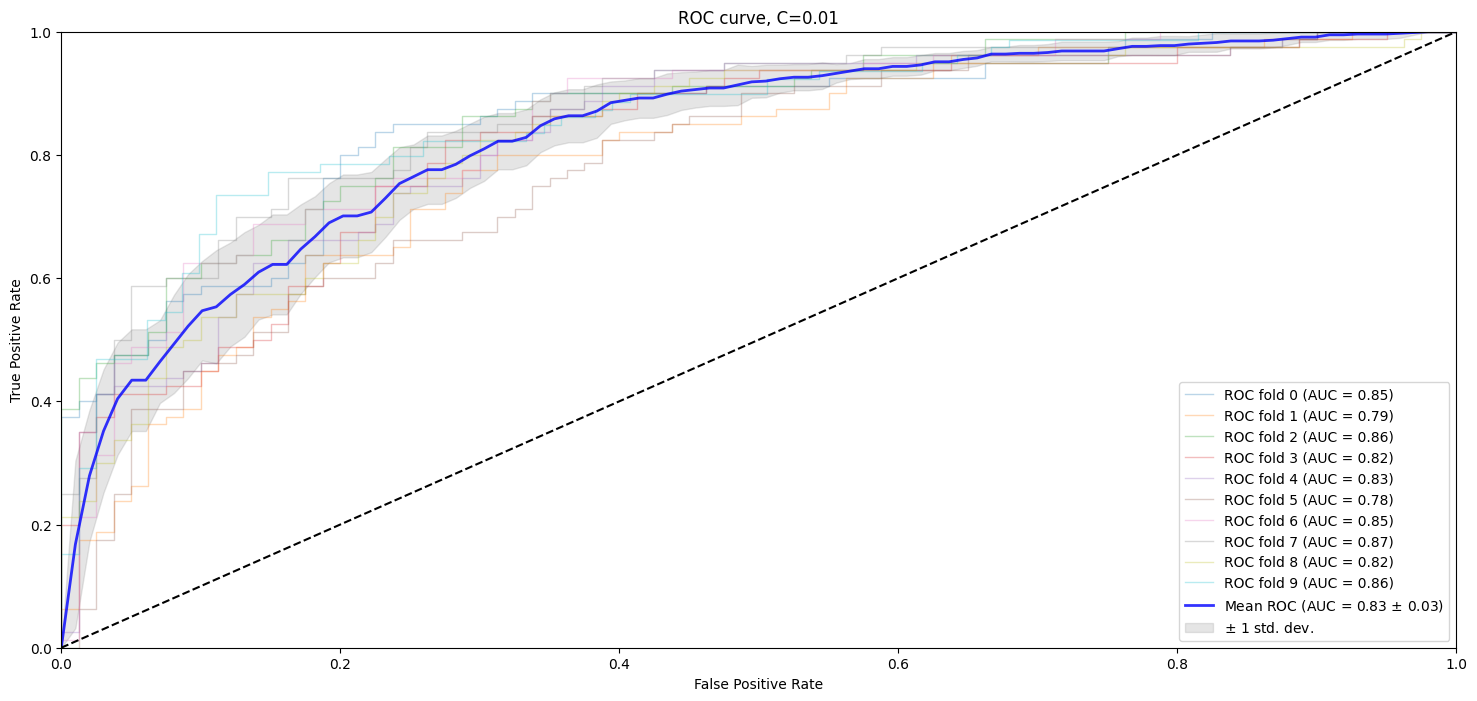

In [ ]:
n_splits = 10
for c in np.linspace(1e-3 * 0.5,1e-2,20):
    classifier = svm.SVC(C=c, kernel="linear")
    plot_roc_with_cv(classifier, X_train, Y_train, n_splits, f"ROC curve, C={c}")

# Test SVM model

In [12]:
# One-Hot Encoding worked better
X_train = pd.get_dummies(raw_train.iloc[:, 0:200]).to_numpy()
Y_train = raw_train['label'].to_numpy()

X_test = pd.get_dummies(raw_test.iloc[:, 0:200]).to_numpy()
Y_test = raw_test['label'].to_numpy()

# C=1e-3 worked best
model = svm.SVC(C=1e-3, kernel="linear")
model = model.fit(X_train, Y_train)

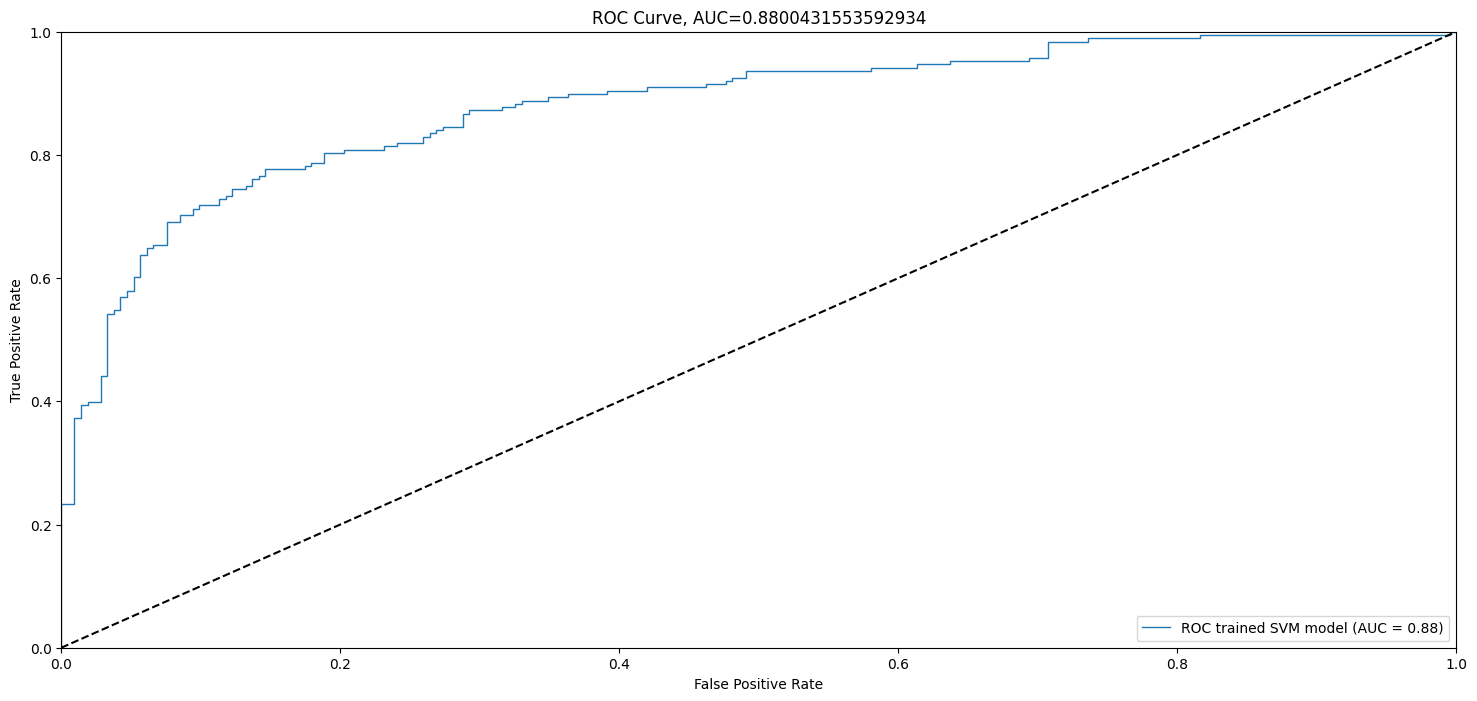

In [13]:
fig, ax = plt.subplots(figsize=(18, 8))
viz = RocCurveDisplay.from_estimator(
    model,
    X_test,
    Y_test,
    name=f"ROC trained SVM model",
    lw=1,
    ax=ax
)
ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"ROC Curve, AUC={viz.roc_auc}",
)
ax.legend(loc="lower right")
ax.plot(np.linspace(0,1,10), np.linspace(0,1,10), '--',color='black')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

# Compare models

## RBPMap fit

### RBP Map predictions, data half positive

In [4]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

with open(fn, 'r') as opened_file:
    txt_lines = opened_file.readlines()

rbp_labels_half_positive = np.array([int(line) for line in txt_lines])
# print(rbp_labels[0:10])

Saving RefrenceRBPMapResultsLabeledShuffled.txt to RefrenceRBPMapResultsLabeledShuffled.txt
User uploaded file "RefrenceRBPMapResultsLabeledShuffled.txt" with length 6000 bytes


### RBP Map True labels (Threshold 1e-4 p value), data half positive

In [5]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

with open(fn, 'r') as opened_file:
    txt_lines = opened_file.readlines()

rbp_true_labels_half_positive = np.array([int(line[0]) for line in txt_lines])
# print(true_labels[0:10])

Saving raw_dataset_half_positive_2.txt to raw_dataset_half_positive_2.txt
User uploaded file "raw_dataset_half_positive_2.txt" with length 408000 bytes


### RBP Map predictions, data fifth positive

In [6]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

with open(fn, 'r') as opened_file:
    txt_lines = opened_file.readlines()

rbp_labels_fifth_positive = np.array([int(line) for line in txt_lines])
# print(rbp_labels[0:10])

Saving RefrenceRBPMapResultsLabeledShuffled_fifth.txt to RefrenceRBPMapResultsLabeledShuffled_fifth.txt
User uploaded file "RefrenceRBPMapResultsLabeledShuffled_fifth.txt" with length 6000 bytes


### RBP Map True labels (Threshold 1e-4 p value), data fifth positive

In [7]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

with open(fn, 'r') as opened_file:
    txt_lines = opened_file.readlines()

rbp_true_labels_fifth_positive = np.array([int(line[0]) for line in txt_lines])
# print(true_labels[0:10])

Saving raw_dataset_fifth_positive.txt to raw_dataset_fifth_positive.txt
User uploaded file "raw_dataset_fifth_positive.txt" with length 408000 bytes


### RBP Map predictions, clean data half positive

In [8]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

with open(fn, 'r') as opened_file:
    txt_lines = opened_file.readlines()

rbp_labels_clean_half_positive = np.array([int(line) for line in txt_lines])
# print(rbp_labels[0:10])

Saving RefrenceRBPMapCleanData_half_positive_labled_shuffled.txt to RefrenceRBPMapCleanData_half_positive_labled_shuffled.txt
User uploaded file "RefrenceRBPMapCleanData_half_positive_labled_shuffled.txt" with length 6000 bytes


### RBP Map True labels (Threshold 1e-4 p value), clean data half positive

In [9]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

with open(fn, 'r') as opened_file:
    txt_lines = opened_file.readlines()

rbp_true_labels_clean_half_positive = np.array([int(line[0]) for line in txt_lines])
# print(true_labels[0:10])

Saving raw_clean_data_half_positive.txt to raw_clean_data_half_positive.txt
User uploaded file "raw_clean_data_half_positive.txt" with length 408000 bytes


### RBP Map predictions, clean data fifth positive

In [10]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

with open(fn, 'r') as opened_file:
    txt_lines = opened_file.readlines()

rbp_labels_clean_fifth_positive = np.array([int(line) for line in txt_lines])
# print(rbp_labels[0:10])

Saving RefrenceRBPMapCleanData_fifth_positive_labled_shuffled.txt to RefrenceRBPMapCleanData_fifth_positive_labled_shuffled.txt
User uploaded file "RefrenceRBPMapCleanData_fifth_positive_labled_shuffled.txt" with length 6000 bytes


### RBP Map True labels (Threshold 1e-4 p value), data fifth positive

In [11]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

with open(fn, 'r') as opened_file:
    txt_lines = opened_file.readlines()

rbp_true_labels_clean_fifth_positive = np.array([int(line[0]) for line in txt_lines])
# print(true_labels[0:10])

Saving raw_clean_data_fifth_positive.txt to raw_clean_data_fifth_positive.txt
User uploaded file "raw_clean_data_fifth_positive.txt" with length 408000 bytes


## SVM model fit

### Fit SVM model with half of the samples positive

In [12]:
raw_dataset_svm_model_half_positive = import_dataset()
[raw_train_svm_model_half_positive, raw_test_svm_model_half_positive] = train_test_split(raw_dataset_svm_model_half_positive,train_size=0.8, random_state=103)
# One-Hot Encoding worked better
X_train_svm_model_half_positive = pd.get_dummies(raw_train_svm_model_half_positive.iloc[:, 0:200]).to_numpy()
Y_train_svm_model_half_positive = raw_train_svm_model_half_positive['label'].to_numpy()

X_test_svm_model_half_positive = pd.get_dummies(raw_test_svm_model_half_positive.iloc[:, 0:200]).to_numpy()
Y_test_svm_model_half_positive = raw_test_svm_model_half_positive['label'].to_numpy()

# C=1e-3 worked best
svm_model_half_positive = svm.SVC(C=1e-3, kernel="linear")
svm_model_half_positive = svm_model_half_positive.fit(X_train_svm_model_half_positive, Y_train_svm_model_half_positive)

Saving raw_dataset_half_positive_2.txt to raw_dataset_half_positive_2 (1).txt
User uploaded file "raw_dataset_half_positive_2 (1).txt" with length 408000 bytes


### Fit SVM model with fifth of the samples positive

In [13]:
raw_dataset_svm_model_fifth_positive = import_dataset()
[raw_train_svm_model_fifth_positive, raw_test_svm_model_fifth_positive] = train_test_split(raw_dataset_svm_model_fifth_positive,train_size=0.8, random_state=103)

# One-Hot Encoding worked better
X_train_svm_model_fifth_positive = pd.get_dummies(raw_train_svm_model_fifth_positive.iloc[:, 0:200]).to_numpy()
Y_train_svm_model_fifth_positive = raw_train_svm_model_fifth_positive['label'].to_numpy()

X_test_svm_model_fifth_positive = pd.get_dummies(raw_test_svm_model_fifth_positive.iloc[:, 0:200]).to_numpy()
Y_test_svm_model_fifth_positive = raw_test_svm_model_fifth_positive['label'].to_numpy()

# C=1e-3 worked best
svm_model_fifth_positive = svm.SVC(C=1e-3, kernel="linear")
svm_model_fifth_positive = svm_model_fifth_positive.fit(X_train_svm_model_fifth_positive, Y_train_svm_model_fifth_positive)

Saving raw_dataset_fifth_positive.txt to raw_dataset_fifth_positive (1).txt
User uploaded file "raw_dataset_fifth_positive (1).txt" with length 408000 bytes


### Fit SVM model with clean data, half of the samples positive

In [21]:
raw_dataset_svm_model_clean_half_positive = import_dataset()
[raw_train_svm_model_clean_half_positive, raw_test_svm_model_clean_half_positive] = train_test_split(raw_dataset_svm_model_clean_half_positive,train_size=0.8, random_state=103)
# One-Hot Encoding worked better
X_train_svm_model_clean_half_positive = pd.get_dummies(raw_train_svm_model_clean_half_positive.iloc[:, 0:200]).to_numpy()
Y_train_svm_model_clean_half_positive = raw_train_svm_model_clean_half_positive['label'].to_numpy()

X_test_svm_model_clean_half_positive = pd.get_dummies(raw_test_svm_model_clean_half_positive.iloc[:, 0:200]).to_numpy()
Y_test_svm_model_clean_half_positive = raw_test_svm_model_clean_half_positive['label'].to_numpy()

# C=1e-3 worked best
svm_model_clean_half_positive = svm.SVC(C=1e-3, kernel="linear")
svm_model_clean_half_positive = svm_model_clean_half_positive.fit(X_train_svm_model_half_positive, Y_train_svm_model_half_positive)

Saving raw_clean_data_half_positive.txt to raw_clean_data_half_positive (3).txt
User uploaded file "raw_clean_data_half_positive (3).txt" with length 408000 bytes


### Fit SVM model with clean data, fifth of the samples positive

In [15]:
raw_dataset_svm_model_clean_fifth_positive = import_dataset()
[raw_train_svm_model_clean_fifth_positive, raw_test_svm_model_clean_fifth_positive] = train_test_split(raw_dataset_svm_model_clean_fifth_positive,train_size=0.8, random_state=103)

# One-Hot Encoding worked better
X_train_svm_model_clean_fifth_positive = pd.get_dummies(raw_train_svm_model_clean_fifth_positive.iloc[:, 0:200]).to_numpy()
Y_train_svm_model_clean_fifth_positive = raw_train_svm_model_clean_fifth_positive['label'].to_numpy()

X_test_svm_model_clean_fifth_positive = pd.get_dummies(raw_test_svm_model_clean_fifth_positive.iloc[:, 0:200]).to_numpy()
Y_test_svm_model_clean_fifth_positive = raw_test_svm_model_clean_fifth_positive['label'].to_numpy()

# C=1e-3 worked best
svm_model_clean_fifth_positive = svm.SVC(C=1e-3, kernel="linear")
svm_model_clean_fifth_positive = svm_model_clean_fifth_positive.fit(X_train_svm_model_fifth_positive, Y_train_svm_model_fifth_positive)

Saving raw_clean_data_fifth_positive.txt to raw_clean_data_fifth_positive (1).txt
User uploaded file "raw_clean_data_fifth_positive (1).txt" with length 408000 bytes


### Fit random SVM model

In [16]:
raw_dataset_svm_model_random = import_dataset()
[raw_train_svm_model_random, raw_test_svm_model_random] = train_test_split(raw_dataset_svm_model_random,train_size=0.8, random_state=103)

# One-Hot Encoding worked better
X_train_svm_model_random = pd.get_dummies(raw_train_svm_model_random.iloc[:, 0:200]).to_numpy()
Y_train_svm_model_random = raw_train_svm_model_random['label'].to_numpy()
np.random.seed(1)
np.random.shuffle(Y_train_svm_model_random)

X_test_svm_model_random = pd.get_dummies(raw_test_svm_model_random.iloc[:, 0:200]).to_numpy()
Y_test_svm_model_random = raw_test_svm_model_random['label'].to_numpy()

# C=1e-3 worked best
svm_model_random = svm.SVC(C=1e-3, kernel="linear")
svm_model_random = svm_model_random.fit(X_train_svm_model_random, Y_train_svm_model_random)

Saving raw_dataset_half_positive_2.txt to raw_dataset_half_positive_2 (2).txt
User uploaded file "raw_dataset_half_positive_2 (2).txt" with length 408000 bytes


## Analyze results

### Noisy data

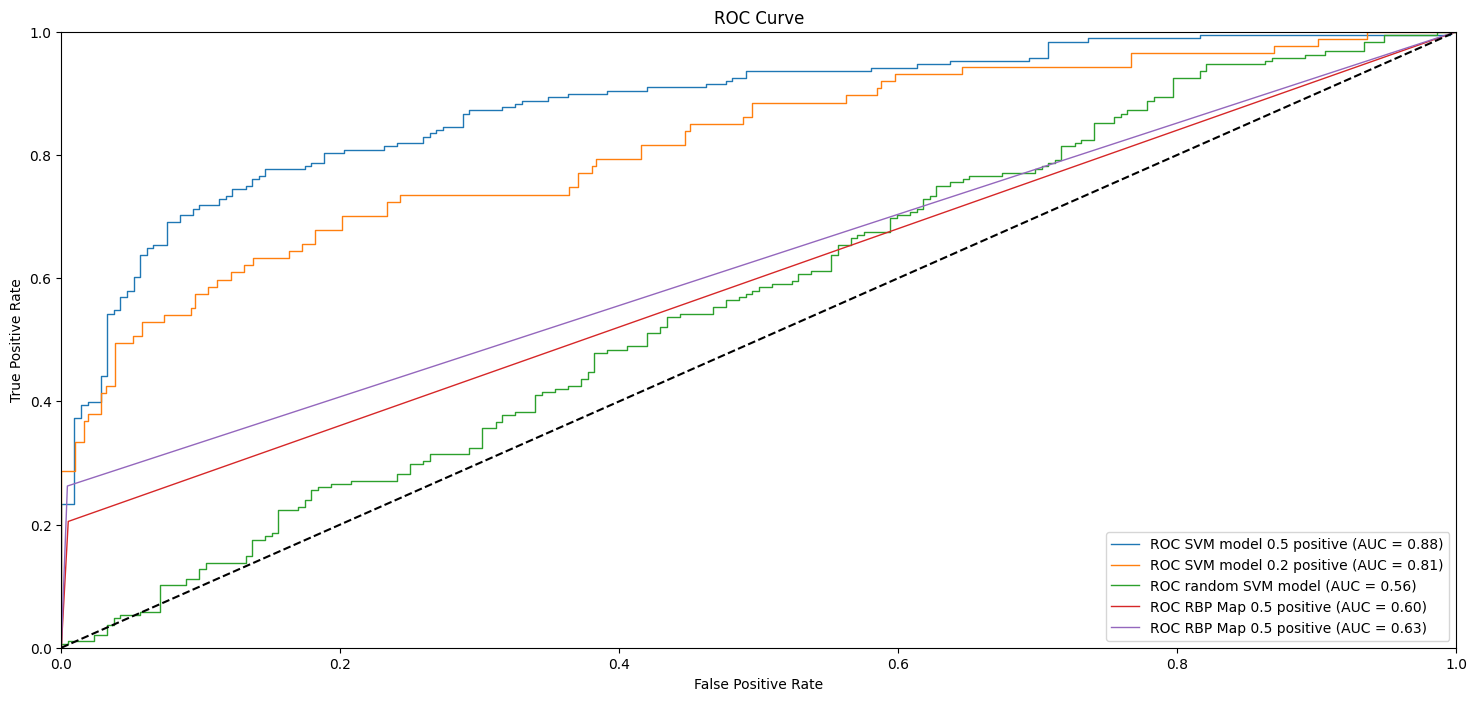

In [17]:
fig, ax = plt.subplots(figsize=(18, 8))

viz = RocCurveDisplay.from_estimator(
    svm_model_half_positive,
    X_test_svm_model_half_positive,
    Y_test_svm_model_half_positive,
    name=f"ROC SVM model 0.5 positive",
    lw=1,
    ax=ax
)

viz = RocCurveDisplay.from_estimator(
    svm_model_fifth_positive,
    X_test_svm_model_fifth_positive,
    Y_test_svm_model_fifth_positive,
    name=f"ROC SVM model 0.2 positive",
    lw=1,
    ax=ax
)

viz = RocCurveDisplay.from_estimator(
    svm_model_random,
    X_test_svm_model_random,
    Y_test_svm_model_random,
    name=f"ROC random SVM model",
    lw=1,
    ax=ax
)

viz = RocCurveDisplay.from_predictions(
    rbp_true_labels_half_positive,
    rbp_labels_half_positive,
    name=f"ROC RBP Map 0.5 positive",
    lw=1,
    ax=ax
)

viz = RocCurveDisplay.from_predictions(
    rbp_true_labels_fifth_positive,
    rbp_labels_fifth_positive,
    name=f"ROC RBP Map 0.5 positive",
    lw=1,
    ax=ax
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"ROC Curve",
)
ax.legend(loc="lower right")
ax.plot(np.linspace(0,1,10), np.linspace(0,1,10), '--',color='black')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

### Clean data

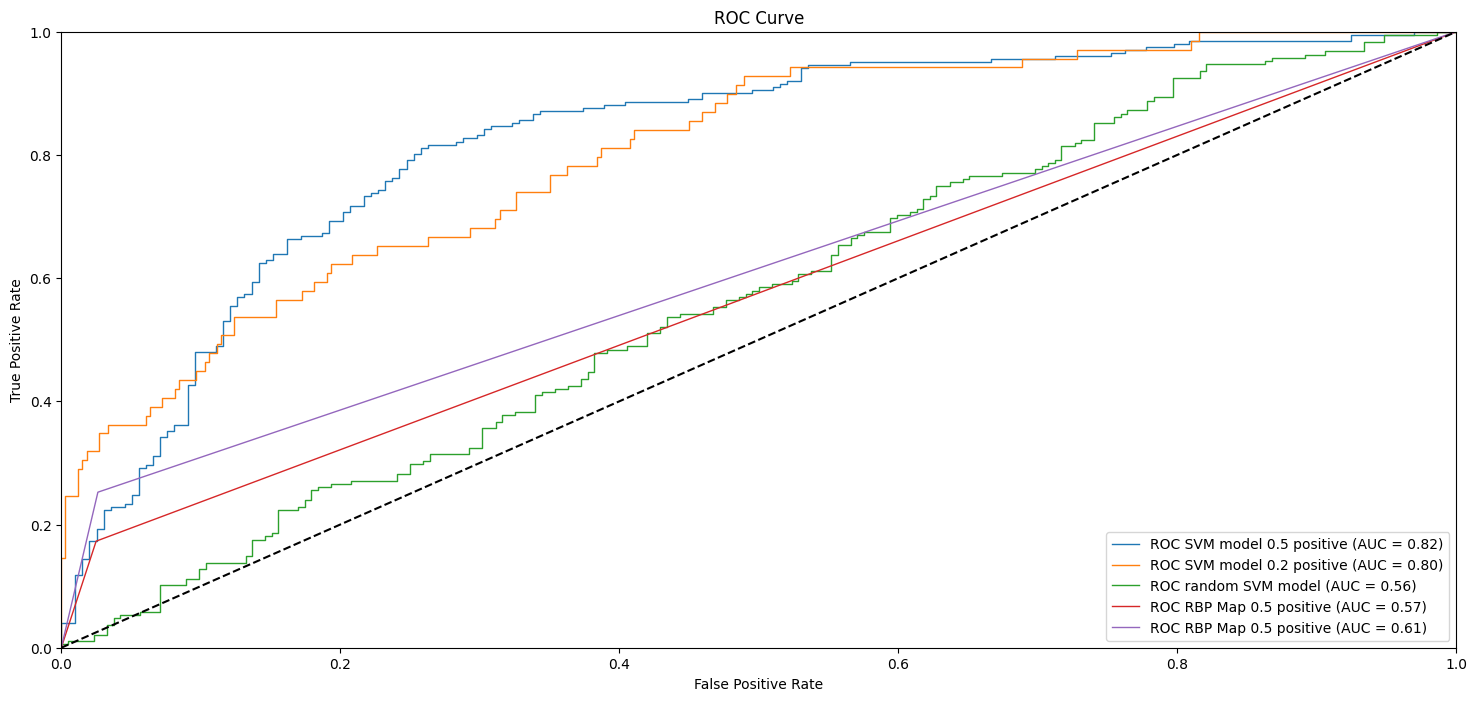

In [23]:
fig, ax = plt.subplots(figsize=(18, 8))

viz = RocCurveDisplay.from_estimator(
    svm_model_clean_half_positive,
    X_test_svm_model_clean_half_positive,
    Y_test_svm_model_clean_half_positive,
    name=f"ROC SVM model 0.5 positive",
    lw=1,
    ax=ax
)

viz = RocCurveDisplay.from_estimator(
    svm_model_clean_fifth_positive,
    X_test_svm_model_clean_fifth_positive,
    Y_test_svm_model_clean_fifth_positive,
    name=f"ROC SVM model 0.2 positive",
    lw=1,
    ax=ax
)

viz = RocCurveDisplay.from_estimator(
    svm_model_random,
    X_test_svm_model_random,
    Y_test_svm_model_random,
    name=f"ROC random SVM model",
    lw=1,
    ax=ax
)

viz = RocCurveDisplay.from_predictions(
    rbp_true_labels_clean_half_positive,
    rbp_labels_clean_half_positive,
    name=f"ROC RBP Map 0.5 positive",
    lw=1,
    ax=ax
)

viz = RocCurveDisplay.from_predictions(
    rbp_true_labels_clean_fifth_positive,
    rbp_labels_clean_fifth_positive,
    name=f"ROC RBP Map 0.5 positive",
    lw=1,
    ax=ax
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"ROC Curve",
)
ax.legend(loc="lower right")
ax.plot(np.linspace(0,1,10), np.linspace(0,1,10), '--',color='black')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

### All data

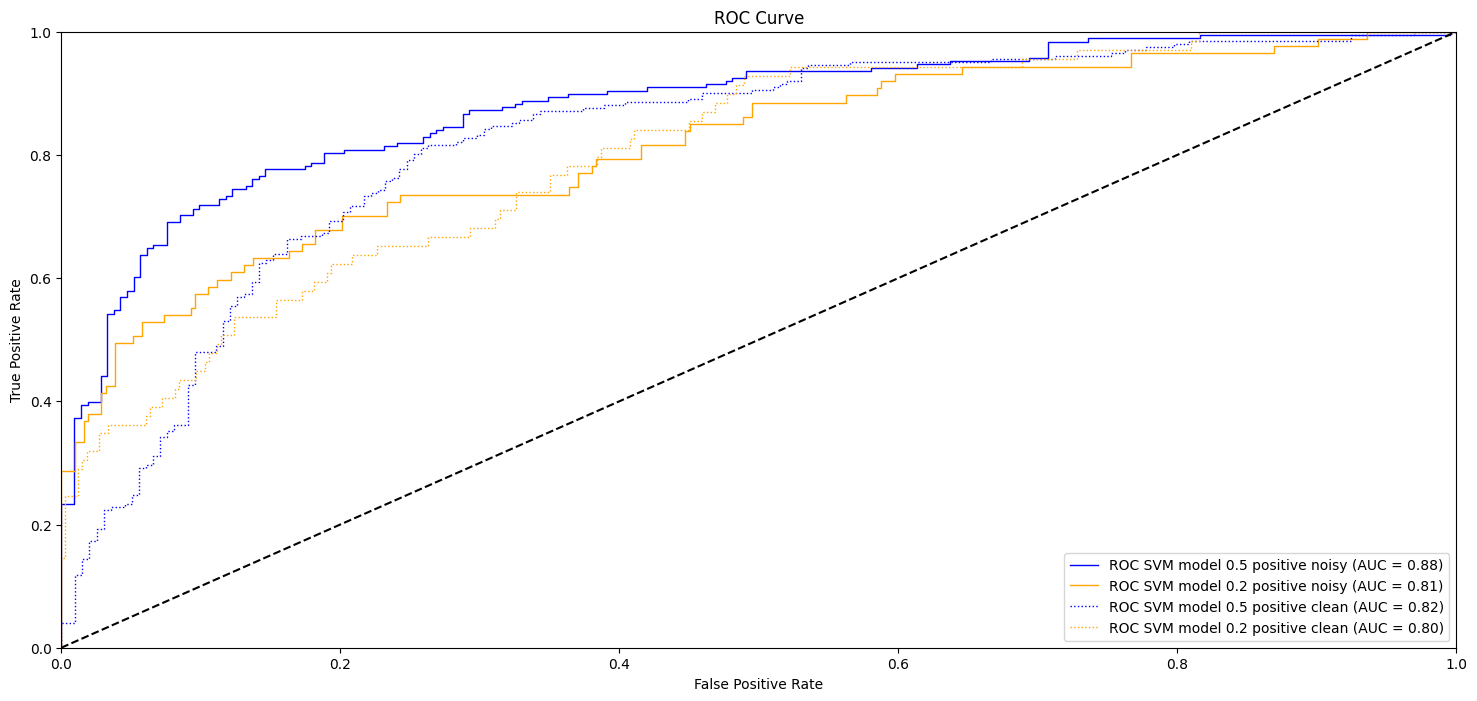

In [33]:
fig, ax = plt.subplots(figsize=(18, 8))

viz = RocCurveDisplay.from_estimator(
    svm_model_half_positive,
    X_test_svm_model_half_positive,
    Y_test_svm_model_half_positive,
    name=f"ROC SVM model 0.5 positive noisy",
    lw=1,
    color='blue',
    ax=ax
)

viz = RocCurveDisplay.from_estimator(
    svm_model_fifth_positive,
    X_test_svm_model_fifth_positive,
    Y_test_svm_model_fifth_positive,
    name=f"ROC SVM model 0.2 positive noisy",
    lw=1,
    color='orange',
    ax=ax
)

viz = RocCurveDisplay.from_estimator(
    svm_model_clean_half_positive,
    X_test_svm_model_clean_half_positive,
    Y_test_svm_model_clean_half_positive,
    name=f"ROC SVM model 0.5 positive clean",
    lw=1,
    color='blue',
    linestyle='dotted',
    ax=ax
)

viz = RocCurveDisplay.from_estimator(
    svm_model_clean_fifth_positive,
    X_test_svm_model_clean_fifth_positive,
    Y_test_svm_model_clean_fifth_positive,
    name=f"ROC SVM model 0.2 positive clean",
    lw=1,
    color='orange',
    linestyle='dotted',
    ax=ax
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"ROC Curve",
)
ax.legend(loc="lower right")
ax.plot(np.linspace(0,1,10), np.linspace(0,1,10), '--',color='black')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()